In [23]:
from polygon import RESTClient
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import yfinance as yf
import time


#works best with constant markets. Does not perform well with bullish or bearish markets

class SimpleMovingAverage:
  def __init__(self, typ, period):
    self.period = period
    self.typ = typ
    self.data = []
    self.avg = -1 # needs updating - at least 1 day(s) of data required
  
  def update(self, new_delta):
    if self.typ == "gain" and new_delta < 0:
      new_delta = 0
    elif self.typ == "loss" and new_delta > 0:
      new_delta = 0
    self.data.append(abs(new_delta))
    if len(self.data) > self.period:
      self.data.pop(0)
    self.avg = sum(self.data) / len(self.data)
  
class RelativeStrengthIndex:
  def __init__(self, period=14):
    self.period = period
    self.last = -1
    self.rsi = -1 # needs updating - more than [period=14] day(s) of data required
    self.count = 0
    self.gain_avg = SimpleMovingAverage("gain", period)
    self.loss_avg = SimpleMovingAverage("loss", period)
  
  def update(self, new_data_point, time=""):
    if self.last >= 0:
      self.gain_avg.update(new_data_point - self.last)
      self.loss_avg.update(new_data_point - self.last)
    self.last = new_data_point
    self.count += 1
    if self.count > self.period:
      self.rsi = 100 - (100 / (1 + self.gain_avg.avg / (0.000000000000000000001 + self.loss_avg.avg)))

def generate_date_array(year):
    dates = []
    # Start from the first day of the given year
    current_date = datetime(year, 1, 1)
    # End on the last day of the given year
    end_date = datetime(year + 1, 1, 1)
    
    while current_date < end_date:
        # Format the date as "yyyy-mm-dd" and add it to the list
        date_string = current_date.strftime("%Y-%m-%d")
        dates.append(date_string)
        # Move to the next day
        current_date += timedelta(days=1)
    
    return dates

def graph_profits(data, type_of_profit):
    # Extract keys and values
    dates = list(data.keys())
    values = list(data.values())

    # Convert string dates to datetime objects
    dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

    # Create a plot
    plt.figure(figsize=(8, 4))
    plt.plot(dates, values, marker='o', linestyle='-', color='b')

    # Format the x-axis to show dates properly
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

    # Label the axes
    plt.xlabel('Date')
    plt.ylabel(type_of_profit)
    plt.title(f'Model {type_of_profit} vs Holding Stock')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()


def graph_transactions(transactions):
  # Convert transactions to a DataFrame for easier manipulation
  df = pd.DataFrame(transactions, columns=['Date', 'Price', 'Type'])

  # Convert the 'Date' column to datetime objects
  df['Date'] = pd.to_datetime(df['Date'])

  # Separate the transactions by type
  sell_transactions = df[df['Type'] == 'Sell']
  buy_transactions = df[df['Type'] == 'Buy']

  # Plotting
  plt.figure(figsize=(10, 6))

  # Plot sell transactions in red
  plt.scatter(sell_transactions['Date'], sell_transactions['Price'], color='red', label='Sell', marker='x')

  # Plot buy transactions in green
  plt.scatter(buy_transactions['Date'], buy_transactions['Price'], color='green', label='Buy', marker='o')

  # Labels and title
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title('Transaction Prices Over Time')
  plt.legend()

  # Format the date on the x-axis
  plt.gcf().autofmt_xdate()

  # Show the plot
  plt.show()

In [24]:
def get_data(ticker, start_date, end_date):
    client = RESTClient("InxdvvQ5aFMwk5xWUpJUCpe8YHcimh8d")
    aggs = client.get_aggs(ticker, 1, "hour", start_date, end_date, limit=50000)
    print("Number of Data Points:",len(aggs))
    return aggs
    
    

In [25]:
def run_simulation(ticker, start_date, end_date, init_cash, init_shares, percent_invest, prices, times, buys, sells):
  transaction_times = sorted(buys + sells)
  transactions = []
  for t in transaction_times:
    price = prices[times.index(t)]
    if t in buys:
      transactions.append([t, price, "Buy"])
    else:
      transactions.append([t, price, "Sell"])
      
  print("Transactions: ", transactions)
  graph_transactions(transactions)
  # Execute Transactions through simulation
  cash = init_cash
  shares = init_shares
  print("Running Simulation for RSI with", ticker, "from", start_date, "to", end_date)
  print("Number of Transactions: ", len(transactions))
  print("Buys: ", len(buys), "Sells: ", len(sells))
  print("Open Price, Close Price: ", prices[0], prices[-1])
  print("Beginning Cash and Shares: ", cash, shares)
  portfolio_val_s = cash + prices[0] * shares
  print("Beginning Portfolio Value: ", portfolio_val_s)
  amt = cash * percent_invest / 100
  for order in transactions:
    if order[2] == "Buy":
      cash -= amt
      shares += amt/order[1]
    else:
      cash += amt
      shares -= amt/order[1]
  print("End Cash and Shares: ", cash, shares)
  portfolio_val_e = cash + prices[-1] * shares
  profit = portfolio_val_e - portfolio_val_s
  profit_percentage = (portfolio_val_e - portfolio_val_s) / portfolio_val_s * 100

  base_profit_percentage = init_shares*(prices[-1]-prices[0])/portfolio_val_s * 100

  print("End Portfolio Value: ", portfolio_val_e)
  print()
  print("Model Profit Percentage: ", profit_percentage)
  print("Market Change w/o trades", base_profit_percentage)
  print()
  print("Model outperforms market by", (profit_percentage - base_profit_percentage), "%") 


  return [cash, shares, profit, profit_percentage, base_profit_percentage]

In [26]:
def invest_rsi(ticker, data, start_date, end_date, cash=100000, shares=1000, percent_invest=20):
  aggs = data
  x_close = []
  y_close = []
  min_diff = 1
  for i in range(0, len(aggs), min_diff):
    agg = aggs[i]
    x_close.append(datetime.fromtimestamp(agg.timestamp // 1000).strftime("%Y-%m-%d %H:%M"))
    y_close.append(agg.close)

  
  #check if there is data for this time period
  if len(y_close) == 0:
    print("no data for this time period and stock")
    return(cash, shares, 0, 0, 0)

  # RSI execution
  data_x = []
  data_y = []
  low = []
  high = []
  rsi = RelativeStrengthIndex()
  last_rsi = -1
  buys = []
  sells = []
  
  # Parameters for trade strategy/execution
  low_threshold = 25
  high_threshold = 75
  
  for time, point in zip(x_close, y_close):
    rsi.update(point, time)
    if rsi.count > rsi.period:
      if last_rsi < 0:
        last_rsi = rsi.rsi
      data_x.append(time)
      data_y.append(rsi.rsi)
      low.append(low_threshold)
      high.append(high_threshold)
      if last_rsi < low_threshold and rsi.rsi >= low_threshold:
        buys.append(time)
      if last_rsi > high_threshold and rsi.rsi <= high_threshold:
        sells.append(time)
      last_rsi = rsi.rsi
      
  plt.figure(figsize=(10, 4))    
  plt.title(ticker + " RSI Indicator with Signals")
  plt.plot(data_x, data_y)
  plt.plot(data_x, low)
  plt.plot(data_x, high)
  for buy in buys:
    plt.axvline(x=buy, color="green")
  for sell in sells:
    plt.axvline(x=sell, color="red")
  ax = plt.gca()
  ax.set_xticks(ax.get_xticks()[::30])
  plt.show()

  plt.figure(figsize=(10, 4))
  plt.plot(x_close, y_close)
  plt.title(ticker + " Stock Price with Buy/Sell by RSI Indicator")
  for buy in buys:
    plt.axvline(x=buy, color="green")
  for sell in sells:
    plt.axvline(x=sell, color="red")
  ax = plt.gca()
  ax.set_xticks(ax.get_xticks()[::30])
  plt.show()

  return run_simulation(ticker, start_date, end_date, cash, shares, percent_invest, y_close, x_close, buys, sells)


In [27]:
def test_model(ticker, data, start_date, end_date, init_cash, init_shares, percent_invest):
    year1 = int(start_date[:4])
    year2 = int(end_date[:4])
    date_array = []
    for year in range(year1, year2+1):
        date_array += generate_date_array(year)

    
    cash, shares, profit, profit_percentage, base_profit_percentage = invest_rsi(ticker, data, start_date, end_date, init_cash, init_shares, percent_invest)
    alpha = profit_percentage - base_profit_percentage

    return alpha, profit_percentage

alphas_dict = {}
profits_dict = {}



In [28]:
top_tickers = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "GOOGL", # Alphabet Inc. (Class A)
    "GOOG",  # Alphabet Inc. (Class C)
    "AMZN",  # Amazon.com Inc.
    "TSLA",  # Tesla Inc.
    "NVDA",  # NVIDIA Corporation
    "BRK.B", # Berkshire Hathaway Inc. (Class B)
    "META",  # Meta Platforms, Inc.
    "UNH",   # UnitedHealth Group Incorporated
    "JNJ",   # Johnson & Johnson
    "V",     # Visa Inc.
    "WMT",   # Walmart Inc.
    "XOM",   # Exxon Mobil Corporation
    "PG",    # Procter & Gamble Co.
    "JPM",   # JPMorgan Chase & Co.
    "MA",    # Mastercard Incorporated
    "LLY",   # Eli Lilly and Company
    "HD",    # The Home Depot, Inc.
    "CVX",   # Chevron Corporation
    "MRK",   # Merck & Co., Inc.
    "PEP",   # PepsiCo, Inc.
    "ABBV",  # AbbVie Inc.
    "KO",    # The Coca-Cola Company
    "SPY",    # S&P 500
    "TQQQ",   # 3x long QQQ
    "QQQ",    # QQQ NASDAQ 100
    "COIN",   # Coinbase
    "MSTR"
]

Invest RSI for AAPL from 2024-07-04 to 2024-09-04
Number of Data Points: 688


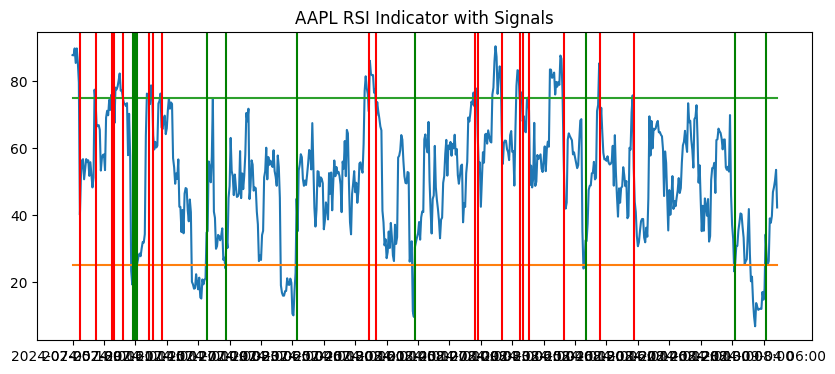

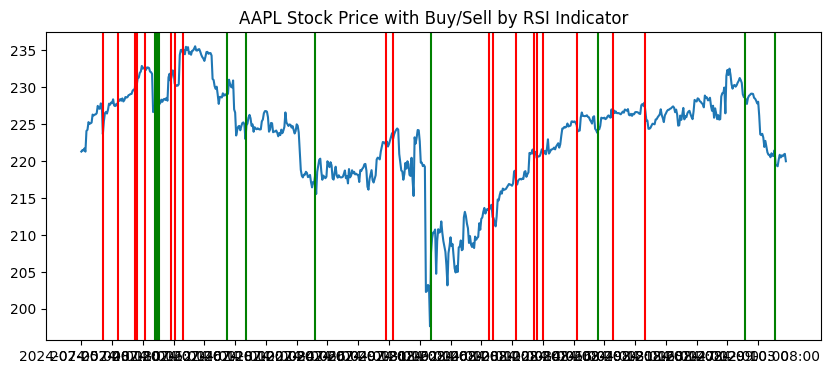

Transactions:  [['2024-07-08 09:00', 223.67, 'Sell'], ['2024-07-09 08:00', 228.3002, 'Sell'], ['2024-07-10 08:00', 229.55, 'Sell'], ['2024-07-10 10:00', 230.2872, 'Sell'], ['2024-07-10 18:00', 232.5018, 'Sell'], ['2024-07-11 12:00', 227.72, 'Buy'], ['2024-07-11 14:00', 227.87, 'Buy'], ['2024-07-11 16:00', 227.71, 'Buy'], ['2024-07-12 11:00', 230.9001, 'Sell'], ['2024-07-12 15:00', 230.56, 'Sell'], ['2024-07-15 07:00', 234.7, 'Sell'], ['2024-07-17 18:00', 229.1859, 'Buy'], ['2024-07-19 05:00', 224.85, 'Buy'], ['2024-07-25 08:00', 218.16, 'Buy'], ['2024-07-31 13:00', 222.17, 'Sell'], ['2024-08-01 04:00', 223.05, 'Sell'], ['2024-08-05 09:00', 207.63, 'Buy'], ['2024-08-08 18:00', 213.465, 'Sell'], ['2024-08-09 05:00', 212.44, 'Sell'], ['2024-08-12 12:00', 217.19, 'Sell'], ['2024-08-13 13:00', 220.93, 'Sell'], ['2024-08-13 16:00', 220.44, 'Sell'], ['2024-08-14 06:00', 221.35, 'Sell'], ['2024-08-16 07:00', 224.9, 'Sell'], ['2024-08-19 12:00', 224.375, 'Buy'], ['2024-08-20 10:00', 225.96, 'Se

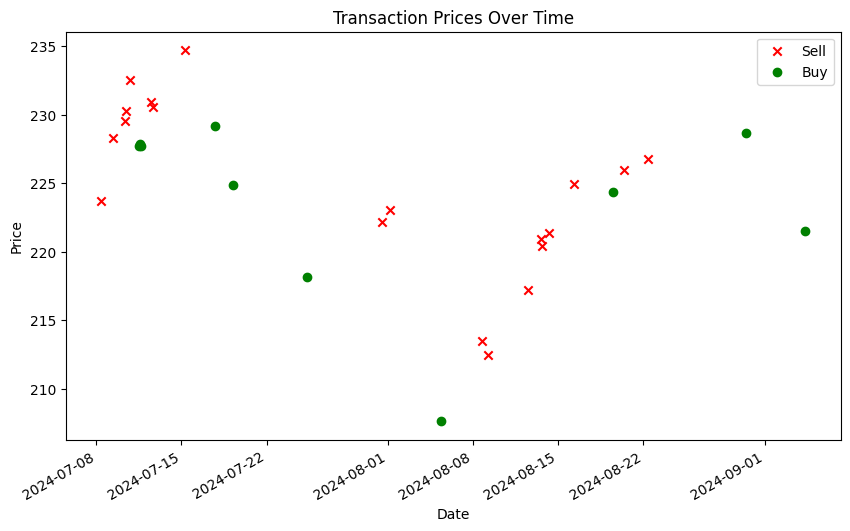

Running Simulation for RSI with AAPL from 2024-07-04 to 2024-09-04
Number of Transactions:  29
Buys:  10 Sells:  19
Open Price, Close Price:  221.31 220
Beginning Cash and Shares:  500000.0 2259.2743210880667
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  725000.0 1261.91398949248
End Portfolio Value:  1002621.0776883456

Model Profit Percentage:  0.26210776883455694
Market Change w/o trades -0.29596493606253726

Model outperforms market by 0.5580727048970942 %


Invest RSI for MSFT from 2024-07-04 to 2024-09-04
Number of Data Points: 688


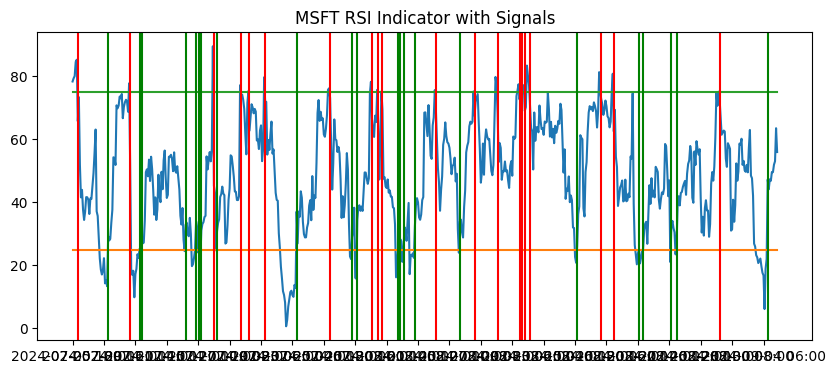

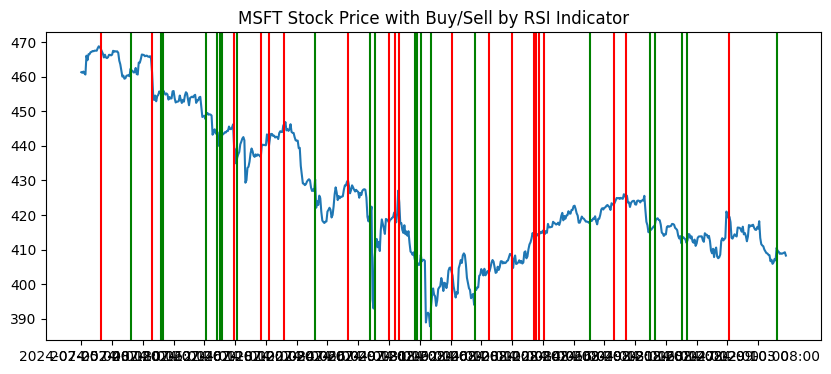

Transactions:  [['2024-07-08 07:00', 468.01, 'Sell'], ['2024-07-10 04:00', 462.29, 'Buy'], ['2024-07-11 09:00', 461.16, 'Sell'], ['2024-07-11 18:00', 455.9968, 'Buy'], ['2024-07-12 04:00', 455.94, 'Buy'], ['2024-07-16 14:00', 449.45, 'Buy'], ['2024-07-17 08:00', 444.17, 'Buy'], ['2024-07-17 11:00', 440.75, 'Buy'], ['2024-07-17 13:00', 443.03, 'Buy'], ['2024-07-18 09:00', 439.44, 'Sell'], ['2024-07-18 12:00', 436.59, 'Buy'], ['2024-07-19 19:00', 436.735, 'Sell'], ['2024-07-22 11:00', 440.08, 'Sell'], ['2024-07-23 10:00', 445.76, 'Sell'], ['2024-07-25 08:00', 430.3, 'Buy'], ['2024-07-29 08:00', 430, 'Sell'], ['2024-07-30 13:00', 419.57, 'Buy'], ['2024-07-30 18:00', 407.69, 'Buy'], ['2024-07-31 16:00', 417.81, 'Sell'], ['2024-08-01 06:00', 420.2, 'Sell'], ['2024-08-01 10:00', 423.71, 'Sell'], ['2024-08-02 09:00', 407.465, 'Buy'], ['2024-08-02 11:00', 406.83, 'Buy'], ['2024-08-02 15:00', 408.49, 'Buy'], ['2024-08-05 09:00', 393.57, 'Buy'], ['2024-08-06 13:00', 403.65, 'Sell'], ['2024-08-08

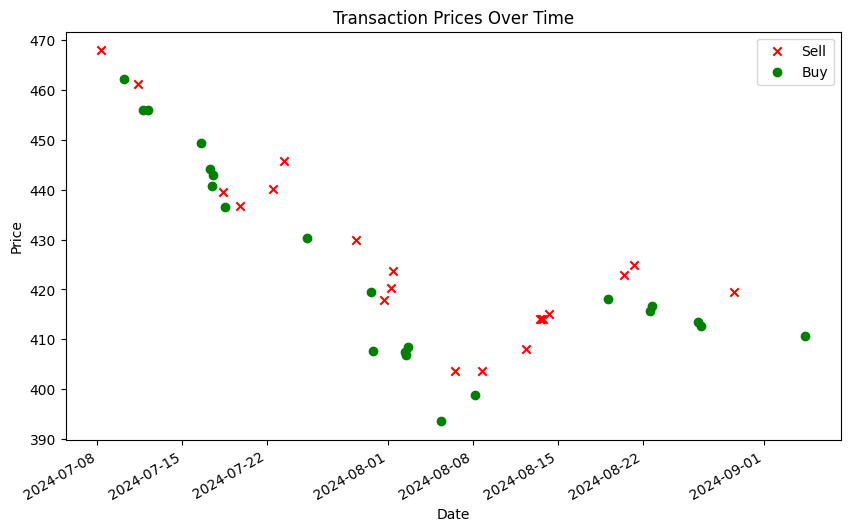

Running Simulation for RSI with MSFT from 2024-07-04 to 2024-09-04
Number of Transactions:  42
Buys:  22 Sells:  20
Open Price, Close Price:  461.26 408.2902
Beginning Cash and Shares:  500000.0 1083.9873390278801
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  450000.0 1205.9792001414091
End Portfolio Value:  942389.488821576

Model Profit Percentage:  -5.7610511178424
Market Change w/o trades -5.741859255083896

Model outperforms market by -0.01919186275850393 %


Invest RSI for GOOGL from 2024-07-04 to 2024-09-04
Number of Data Points: 688


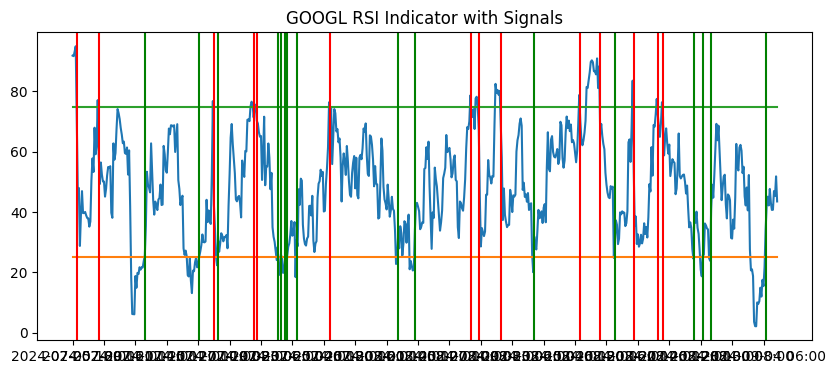

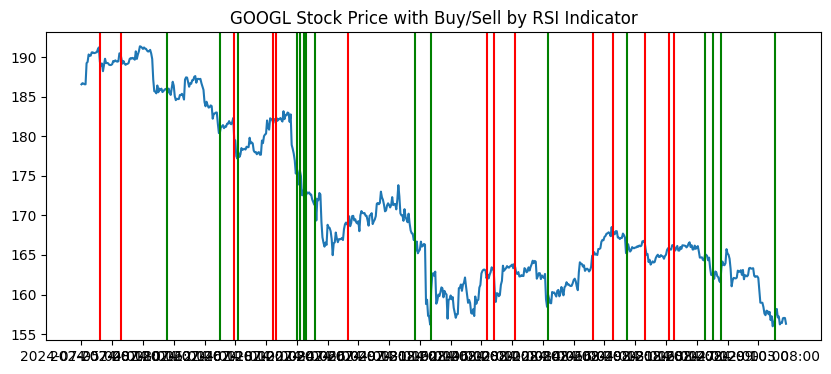

Transactions:  [['2024-07-08 06:00', 189.37, 'Sell'], ['2024-07-09 11:00', 189.765, 'Sell'], ['2024-07-12 07:00', 185.9, 'Buy'], ['2024-07-17 11:00', 180.453, 'Buy'], ['2024-07-18 09:00', 179.51, 'Sell'], ['2024-07-18 13:00', 177.9, 'Buy'], ['2024-07-22 15:00', 181.64, 'Sell'], ['2024-07-22 18:00', 182.35, 'Sell'], ['2024-07-24 06:00', 176, 'Buy'], ['2024-07-24 09:00', 175.67, 'Buy'], ['2024-07-24 13:00', 173.35, 'Buy'], ['2024-07-24 15:00', 172.56, 'Buy'], ['2024-07-25 08:00', 172.24, 'Buy'], ['2024-07-29 08:00', 169.15, 'Sell'], ['2024-08-02 09:00', 167.175, 'Buy'], ['2024-08-05 09:00', 160.505, 'Buy'], ['2024-08-08 15:00', 162.05, 'Sell'], ['2024-08-09 06:00', 163.04, 'Sell'], ['2024-08-12 11:00', 163.41, 'Sell'], ['2024-08-14 11:00', 159.9902, 'Buy'], ['2024-08-19 07:00', 164.96, 'Sell'], ['2024-08-20 10:00', 167.35, 'Sell'], ['2024-08-21 08:00', 165.22, 'Buy'], ['2024-08-22 10:00', 165.8399, 'Sell'], ['2024-08-23 17:00', 165.65, 'Sell'], ['2024-08-26 06:00', 166.06, 'Sell'], ['202

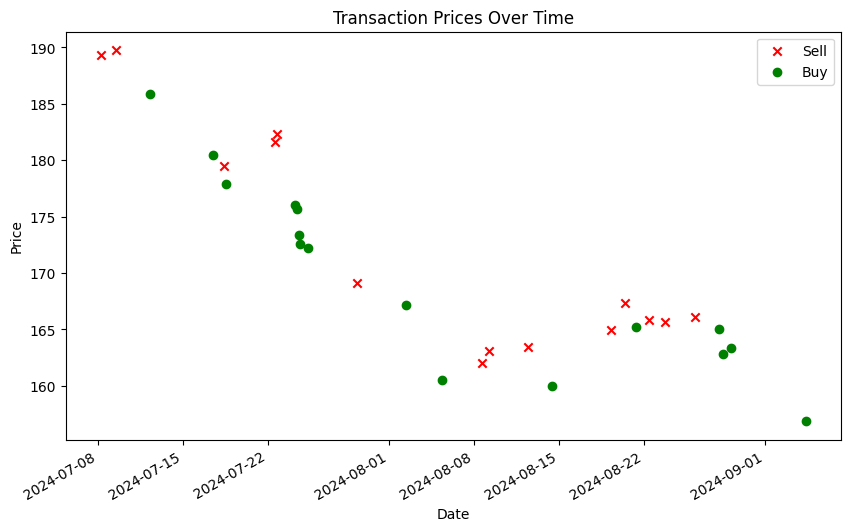

Running Simulation for RSI with GOOGL from 2024-07-04 to 2024-09-04
Number of Transactions:  30
Buys:  16 Sells:  14
Open Price, Close Price:  186.55 156.31
Beginning Cash and Shares:  500000.0 2680.246582685607
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  450000.0 3003.4284243408156
End Portfolio Value:  919465.8970087129

Model Profit Percentage:  -8.053410299128712
Market Change w/o trades -8.105065666041277

Model outperforms market by 0.05165536691256456 %


Invest RSI for GOOG from 2024-07-04 to 2024-09-04
Number of Data Points: 688


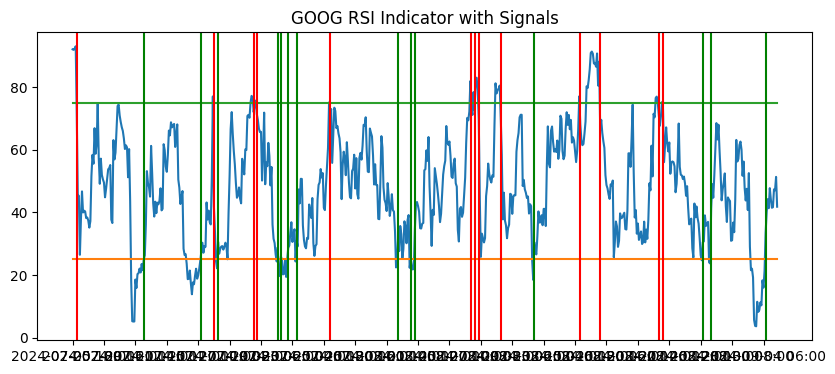

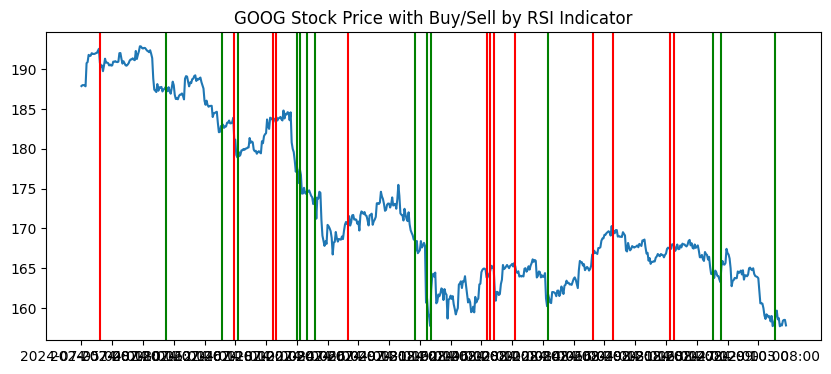

Transactions:  [['2024-07-08 06:00', 190.8, 'Sell'], ['2024-07-12 06:00', 187.75, 'Buy'], ['2024-07-17 13:00', 182.9, 'Buy'], ['2024-07-18 09:00', 181.14, 'Sell'], ['2024-07-18 13:00', 179.65, 'Buy'], ['2024-07-22 15:00', 183.33, 'Sell'], ['2024-07-22 18:00', 183.99, 'Sell'], ['2024-07-24 06:00', 177.88, 'Buy'], ['2024-07-24 09:00', 177.42, 'Buy'], ['2024-07-24 16:00', 174.69, 'Buy'], ['2024-07-25 08:00', 173.99, 'Buy'], ['2024-07-29 08:00', 170.808, 'Sell'], ['2024-08-02 09:00', 168.81, 'Buy'], ['2024-08-05 05:00', 161.17, 'Buy'], ['2024-08-05 09:00', 162.27, 'Buy'], ['2024-08-08 15:00', 163.84, 'Sell'], ['2024-08-08 18:00', 164.37, 'Sell'], ['2024-08-09 06:00', 164.91, 'Sell'], ['2024-08-12 11:00', 165.24, 'Sell'], ['2024-08-14 11:00', 161.7101, 'Buy'], ['2024-08-19 07:00', 166.75, 'Sell'], ['2024-08-20 10:00', 169.16, 'Sell'], ['2024-08-23 18:00', 167.49, 'Sell'], ['2024-08-26 06:00', 167.81, 'Sell'], ['2024-08-28 12:00', 164.56, 'Buy'], ['2024-08-29 04:00', 165.17, 'Buy'], ['2024-0

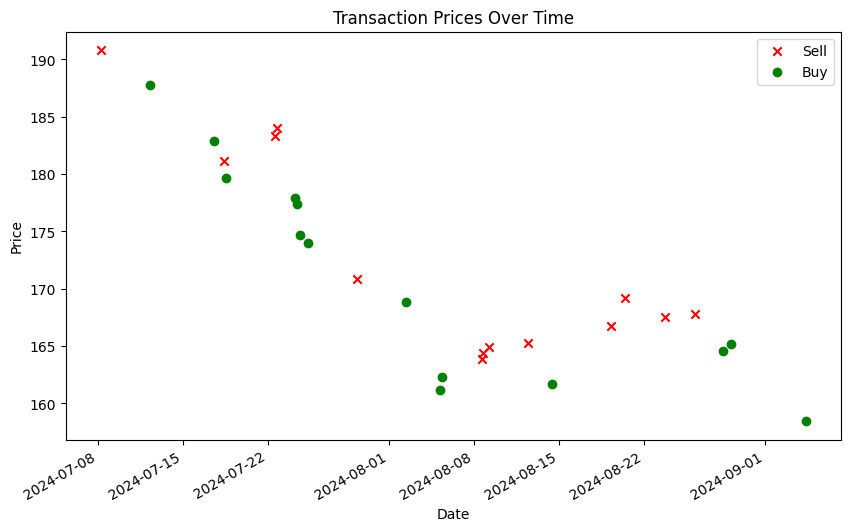

Running Simulation for RSI with GOOG from 2024-07-04 to 2024-09-04
Number of Transactions:  27
Buys:  14 Sells:  13
Open Price, Close Price:  187.88 157.81
Beginning Cash and Shares:  500000.0 2661.2731530764318
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  475000.0 2820.2762461681673
End Portfolio Value:  920067.7944077984

Model Profit Percentage:  -7.9932205592201555
Market Change w/o trades -8.002448371300828

Model outperforms market by 0.009227812080672138 %


Invest RSI for AMZN from 2024-07-04 to 2024-09-04
Number of Data Points: 688


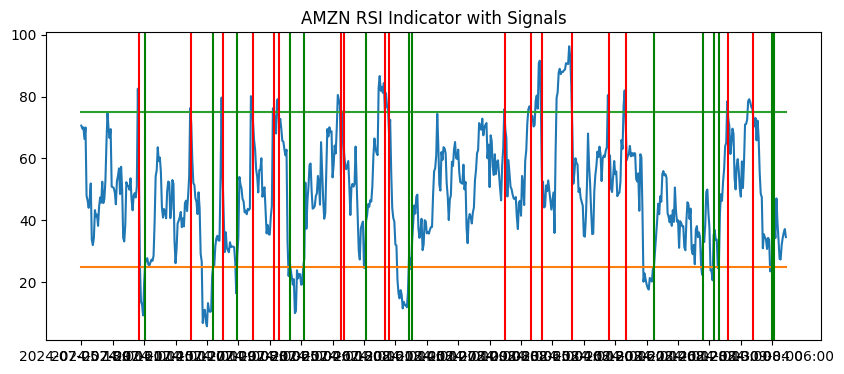

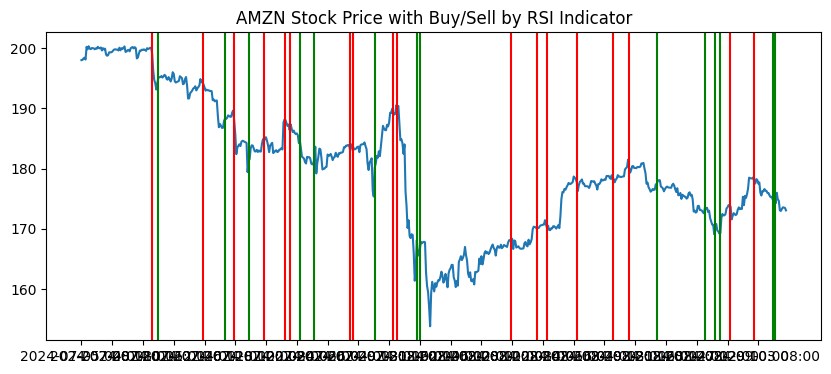

Transactions:  [['2024-07-11 09:00', 198.935, 'Sell'], ['2024-07-11 15:00', 195.06, 'Buy'], ['2024-07-16 11:00', 193.9801, 'Sell'], ['2024-07-17 16:00', 188.3, 'Buy'], ['2024-07-18 09:00', 187.835, 'Sell'], ['2024-07-19 07:00', 181.29, 'Buy'], ['2024-07-22 06:00', 184.5, 'Sell'], ['2024-07-23 10:00', 188.15, 'Sell'], ['2024-07-23 15:00', 186.39, 'Sell'], ['2024-07-24 09:00', 184.63, 'Buy'], ['2024-07-25 07:00', 181.5, 'Buy'], ['2024-07-29 10:00', 182.96, 'Sell'], ['2024-07-29 13:00', 183.53, 'Sell'], ['2024-07-30 18:00', 180.15, 'Buy'], ['2024-08-01 04:00', 188.78, 'Sell'], ['2024-08-01 08:00', 190.08, 'Sell'], ['2024-08-02 11:00', 168.1, 'Buy'], ['2024-08-02 14:00', 166.61, 'Buy'], ['2024-08-12 07:00', 168.25, 'Sell'], ['2024-08-13 16:00', 169.96, 'Sell'], ['2024-08-14 10:00', 170.08, 'Sell'], ['2024-08-16 07:00', 177.75, 'Sell'], ['2024-08-20 10:00', 178.1199, 'Sell'], ['2024-08-21 10:00', 180.17, 'Sell'], ['2024-08-23 05:00', 177.42, 'Buy'], ['2024-08-28 04:00', 173.56, 'Buy'], ['20

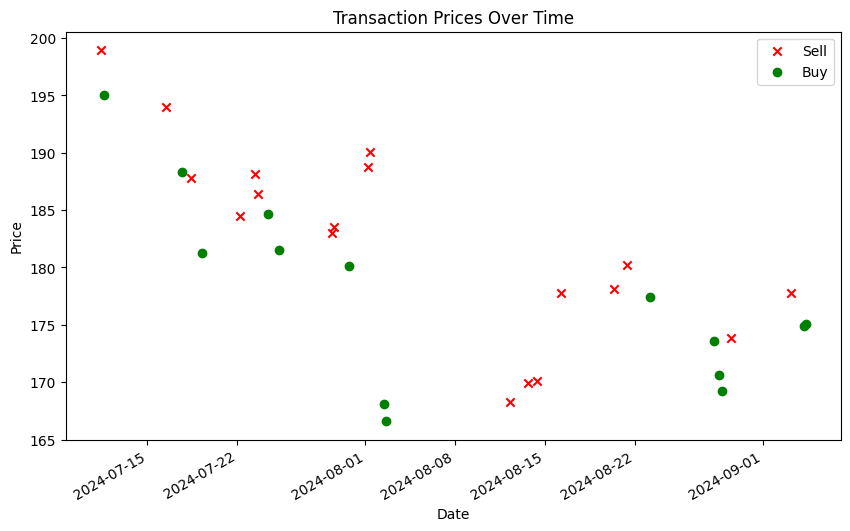

Running Simulation for RSI with AMZN from 2024-07-04 to 2024-09-04
Number of Transactions:  32
Buys:  14 Sells:  18
Open Price, Close Price:  198 173.05
Beginning Cash and Shares:  500000.0 2525.252525252525
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  600000.0 2025.884979813906
End Portfolio Value:  950579.3957567965

Model Profit Percentage:  -4.942060424320354
Market Change w/o trades -6.300505050505047

Model outperforms market by 1.358444626184693 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for TSLA from 2024-07-04 to 2024-09-04
Number of Data Points: 688


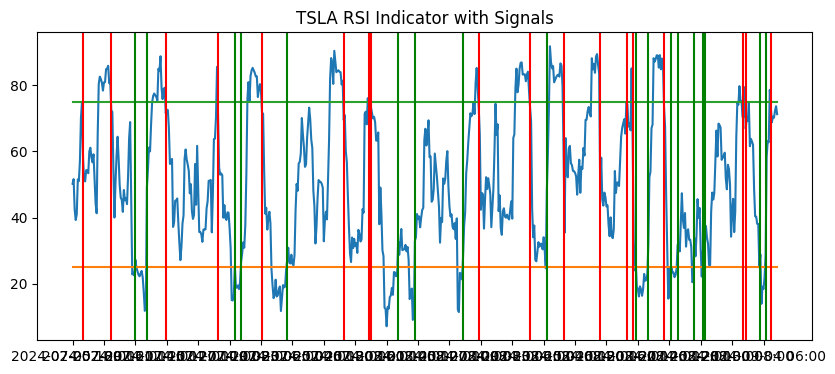

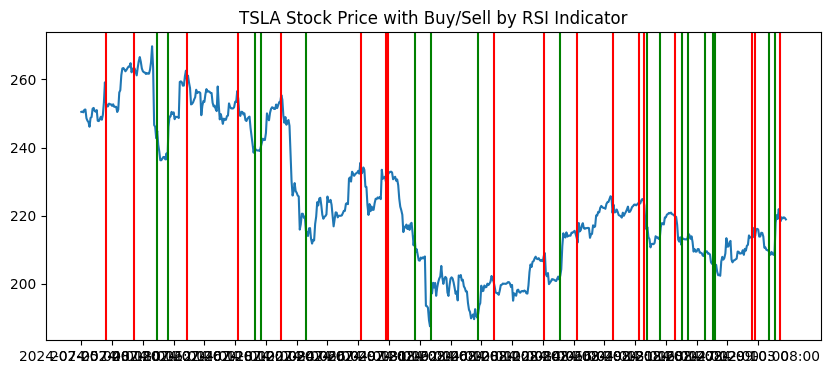

Transactions:  [['2024-07-08 12:00', 253.2676, 'Sell'], ['2024-07-10 07:00', 262.8, 'Sell'], ['2024-07-11 14:00', 244.8808, 'Buy'], ['2024-07-12 09:00', 246.15, 'Buy'], ['2024-07-15 11:00', 259.723, 'Sell'], ['2024-07-18 13:00', 254.35, 'Sell'], ['2024-07-19 13:00', 240.27, 'Buy'], ['2024-07-19 19:00', 240.19, 'Buy'], ['2024-07-23 07:00', 255.46, 'Sell'], ['2024-07-24 15:00', 215.5, 'Buy'], ['2024-07-30 05:00', 232.3, 'Sell'], ['2024-07-31 13:00', 230.0413, 'Sell'], ['2024-07-31 15:00', 232.1, 'Sell'], ['2024-08-02 09:00', 213.925, 'Buy'], ['2024-08-05 09:00', 197.652, 'Buy'], ['2024-08-08 07:00', 191.14, 'Buy'], ['2024-08-09 06:00', 200.65, 'Sell'], ['2024-08-14 07:00', 208.18, 'Sell'], ['2024-08-15 07:00', 202.32, 'Buy'], ['2024-08-16 07:00', 213.5, 'Sell'], ['2024-08-20 10:00', 220.8, 'Sell'], ['2024-08-22 04:00', 224, 'Sell'], ['2024-08-22 09:00', 223, 'Sell'], ['2024-08-22 12:00', 216.585, 'Buy'], ['2024-08-23 08:00', 213.25, 'Buy'], ['2024-08-26 07:00', 219.68, 'Sell'], ['2024-08

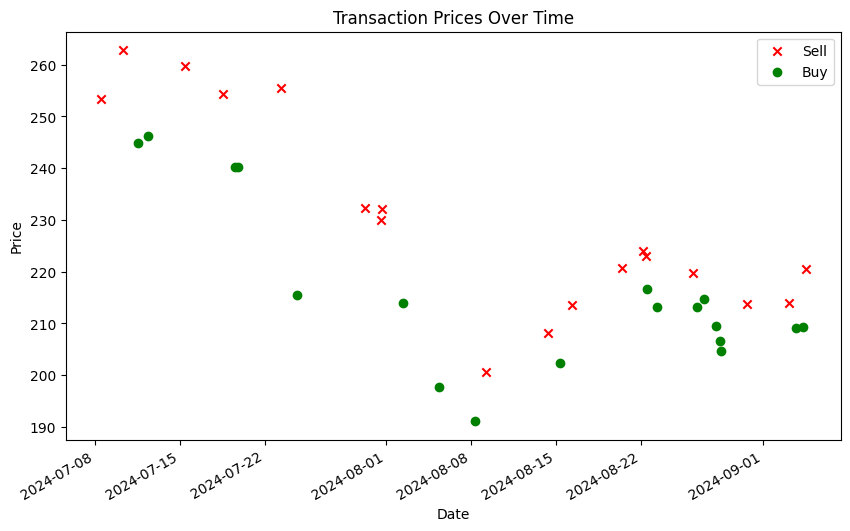

Running Simulation for RSI with TSLA from 2024-07-04 to 2024-09-04
Number of Transactions:  36
Buys:  18 Sells:  18
Open Price, Close Price:  250.48 218.88
Beginning Cash and Shares:  500000.0 1996.1673586713512
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 2119.480619983901
End Portfolio Value:  963911.9181020763

Model Profit Percentage:  -3.6088081897923723
Market Change w/o trades -6.30788885340147

Model outperforms market by 2.6990806636090974 %


Invest RSI for NVDA from 2024-07-04 to 2024-09-04
Number of Data Points: 688


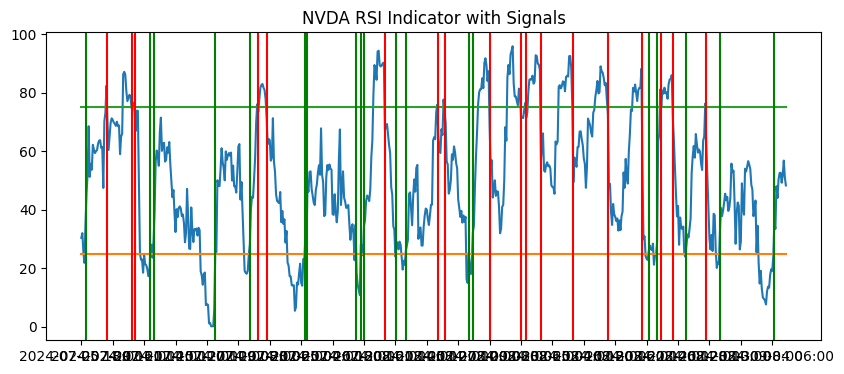

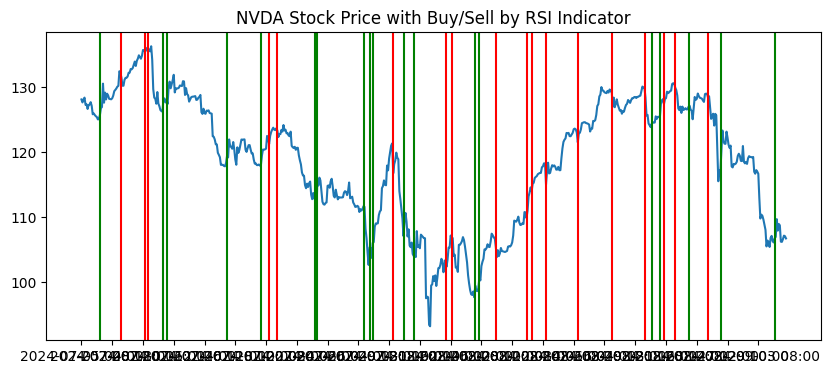

Transactions:  [['2024-07-08 06:00', 125.68, 'Buy'], ['2024-07-09 11:00', 131.4198, 'Sell'], ['2024-07-10 18:00', 135.53, 'Sell'], ['2024-07-11 05:00', 135.96, 'Sell'], ['2024-07-12 04:00', 128.28, 'Buy'], ['2024-07-12 07:00', 128.08, 'Buy'], ['2024-07-17 18:00', 119.45, 'Buy'], ['2024-07-19 19:00', 118, 'Buy'], ['2024-07-22 11:00', 121.23, 'Sell'], ['2024-07-22 19:00', 123.33, 'Sell'], ['2024-07-25 08:00', 113.76, 'Buy'], ['2024-07-25 10:00', 115.4795, 'Buy'], ['2024-07-30 08:00', 111.5597, 'Buy'], ['2024-07-30 13:00', 105.3296, 'Buy'], ['2024-07-30 16:00', 106.02, 'Buy'], ['2024-08-01 04:00', 116.71, 'Sell'], ['2024-08-01 15:00', 109.34, 'Buy'], ['2024-08-02 08:00', 104, 'Buy'], ['2024-08-06 07:00', 103.41, 'Sell'], ['2024-08-06 13:00', 106.7499, 'Sell'], ['2024-08-08 04:00', 99.45, 'Buy'], ['2024-08-08 08:00', 100.64, 'Buy'], ['2024-08-09 08:00', 105.44, 'Sell'], ['2024-08-13 06:00', 109.83, 'Sell'], ['2024-08-13 11:00', 113.9801, 'Sell'], ['2024-08-14 09:00', 115.01, 'Sell'], ['202

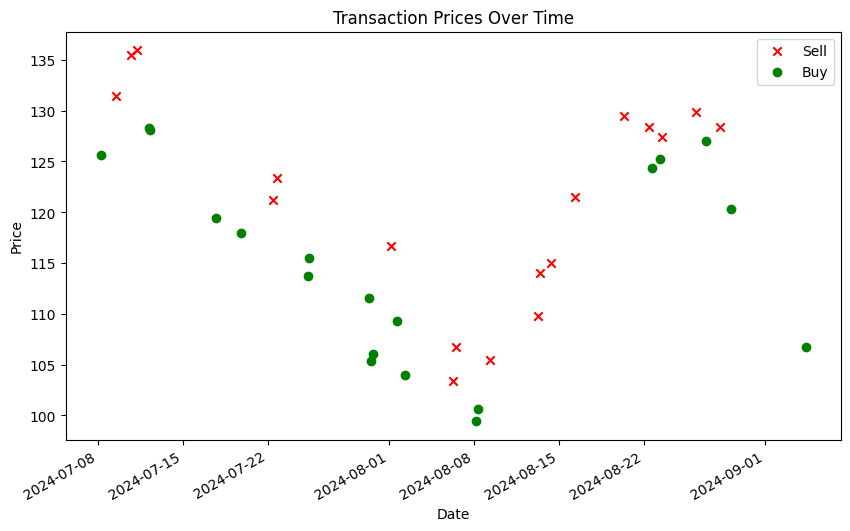

Running Simulation for RSI with NVDA from 2024-07-04 to 2024-09-04
Number of Transactions:  37
Buys:  19 Sells:  18
Open Price, Close Price:  128.09 106.7
Beginning Cash and Shares:  500000.0 3903.5053478023265
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  475000.0 4319.342409394119
End Portfolio Value:  935873.8350823526

Model Profit Percentage:  -6.412616491764737
Market Change w/o trades -8.349597938949177

Model outperforms market by 1.93698144718444 %


Invest RSI for BRK.B from 2024-07-04 to 2024-09-04
Number of Data Points: 626


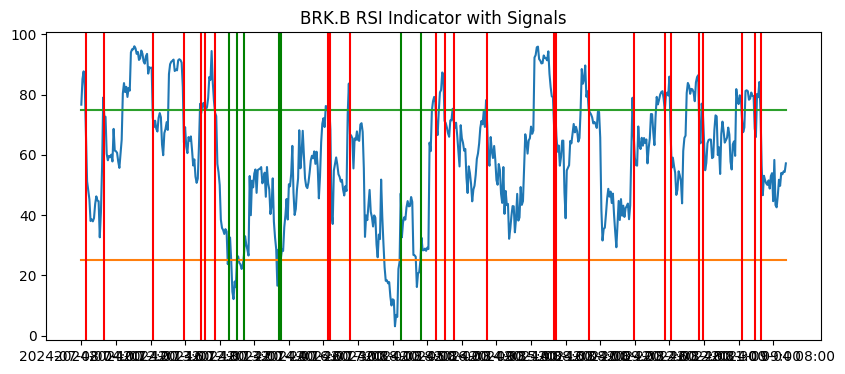

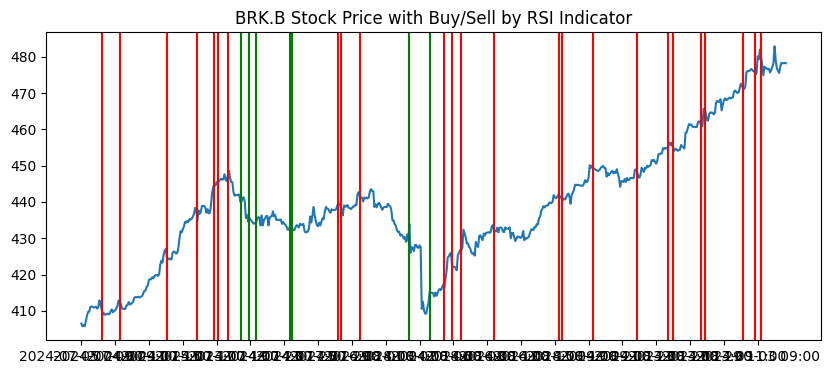

Transactions:  [['2024-07-08 11:00', 410.505, 'Sell'], ['2024-07-09 13:00', 412.41, 'Sell'], ['2024-07-12 15:00', 424.48, 'Sell'], ['2024-07-16 11:00', 434.8799, 'Sell'], ['2024-07-17 12:00', 444.92, 'Sell'], ['2024-07-17 15:00', 445.67, 'Sell'], ['2024-07-18 09:00', 447.3499, 'Sell'], ['2024-07-19 05:00', 440.01, 'Buy'], ['2024-07-19 13:00', 435.67, 'Buy'], ['2024-07-19 19:00', 434.2, 'Buy'], ['2024-07-24 07:00', 433.11, 'Buy'], ['2024-07-24 09:00', 432.005, 'Buy'], ['2024-07-29 06:00', 439.33, 'Sell'], ['2024-07-29 08:00', 439.48, 'Sell'], ['2024-07-30 11:00', 441.645, 'Sell'], ['2024-08-02 09:00', 434, 'Buy'], ['2024-08-05 11:00', 415.2472, 'Buy'], ['2024-08-06 08:00', 416.4, 'Sell'], ['2024-08-06 15:00', 421.84, 'Sell'], ['2024-08-07 07:00', 426.4, 'Sell'], ['2024-08-09 07:00', 432.11, 'Sell'], ['2024-08-15 13:00', 441.3032, 'Sell'], ['2024-08-15 15:00', 440.94, 'Sell'], ['2024-08-19 13:00', 449.26, 'Sell'], ['2024-08-22 11:00', 448.25, 'Sell'], ['2024-08-26 08:00', 454.89, 'Sell']

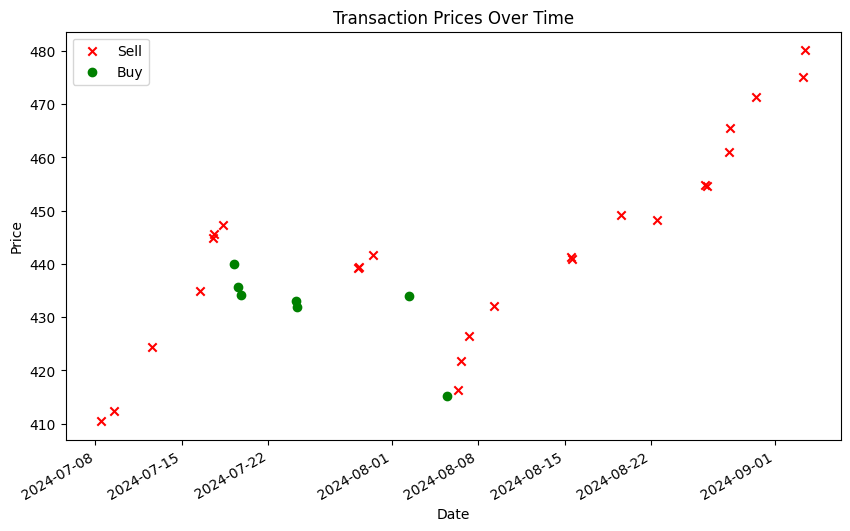

Running Simulation for RSI with BRK.B from 2024-07-04 to 2024-09-04
Number of Transactions:  32
Buys:  7 Sells:  25
Open Price, Close Price:  406.49 478.2
Beginning Cash and Shares:  500000.0 1230.0425594725577
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  950000.0 222.6035389980156
End Portfolio Value:  1056449.012348851

Model Profit Percentage:  5.644901234885095
Market Change w/o trades 8.82063519397771

Model outperforms market by -3.1757339590926144 %


Invest RSI for META from 2024-07-04 to 2024-09-04
Number of Data Points: 686


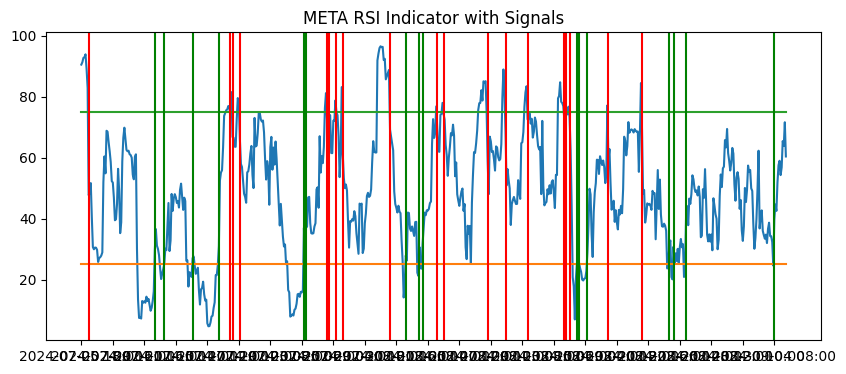

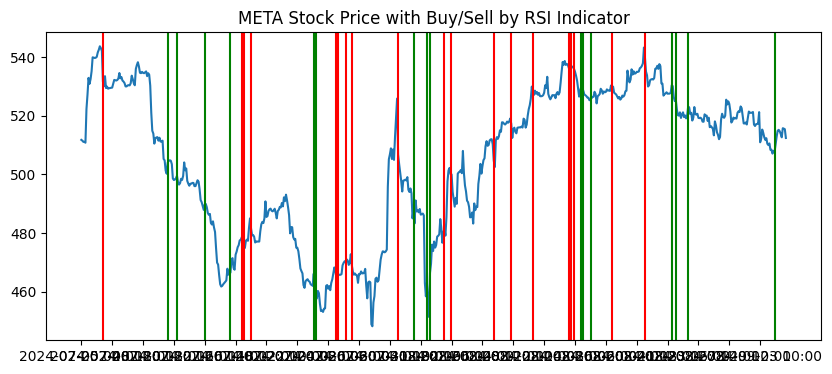

Transactions:  [['2024-07-08 09:00', 531.66, 'Sell'], ['2024-07-12 10:00', 504.03, 'Buy'], ['2024-07-12 19:00', 499.53, 'Buy'], ['2024-07-16 14:00', 489.78, 'Buy'], ['2024-07-18 07:00', 466.5, 'Buy'], ['2024-07-18 18:00', 478.5654, 'Sell'], ['2024-07-19 04:00', 475.01, 'Sell'], ['2024-07-19 11:00', 481.5799, 'Sell'], ['2024-07-25 08:00', 466.15, 'Buy'], ['2024-07-25 10:00', 458.11, 'Buy'], ['2024-07-26 14:00', 464.73, 'Sell'], ['2024-07-26 16:00', 465.61, 'Sell'], ['2024-07-29 07:00', 470.29, 'Sell'], ['2024-07-29 13:00', 469.0146, 'Sell'], ['2024-08-01 10:00', 506.7999, 'Sell'], ['2024-08-02 09:00', 488.2616, 'Buy'], ['2024-08-05 06:00', 463, 'Buy'], ['2024-08-05 09:00', 466.44, 'Buy'], ['2024-08-06 07:00', 481.71, 'Sell'], ['2024-08-06 13:00', 500.11, 'Sell'], ['2024-08-09 07:00', 504.7, 'Sell'], ['2024-08-12 08:00', 517.28, 'Sell'], ['2024-08-13 13:00', 526.82, 'Sell'], ['2024-08-15 16:00', 536.26, 'Sell'], ['2024-08-15 18:00', 536.35, 'Sell'], ['2024-08-16 05:00', 536, 'Sell'], ['2

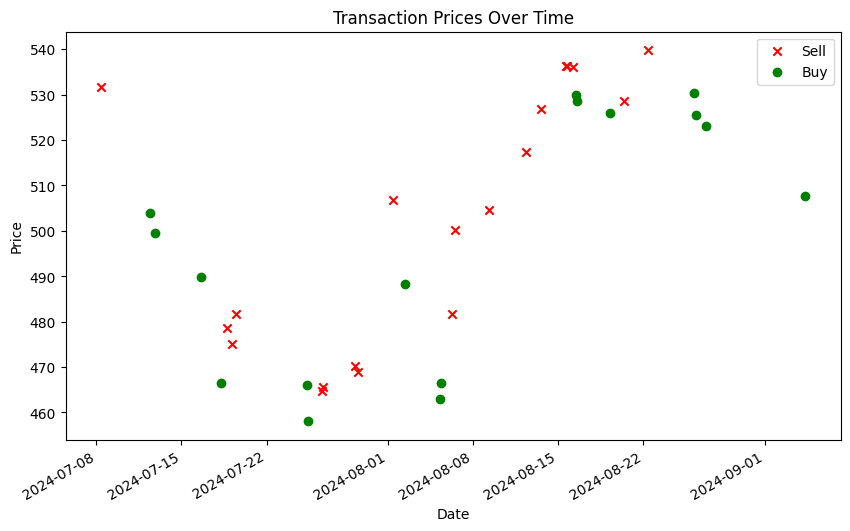

Running Simulation for RSI with META from 2024-07-04 to 2024-09-04
Number of Transactions:  35
Buys:  16 Sells:  19
Open Price, Close Price:  511.77 512.415
Beginning Cash and Shares:  500000.0 977.00138734197
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  575000.0 834.2619324344753
End Portfolio Value:  1002488.3281084116

Model Profit Percentage:  0.24883281084116313
Market Change w/o trades 0.06301658948355529

Model outperforms market by 0.18581622135760784 %


Invest RSI for UNH from 2024-07-04 to 2024-09-04
Number of Data Points: 456


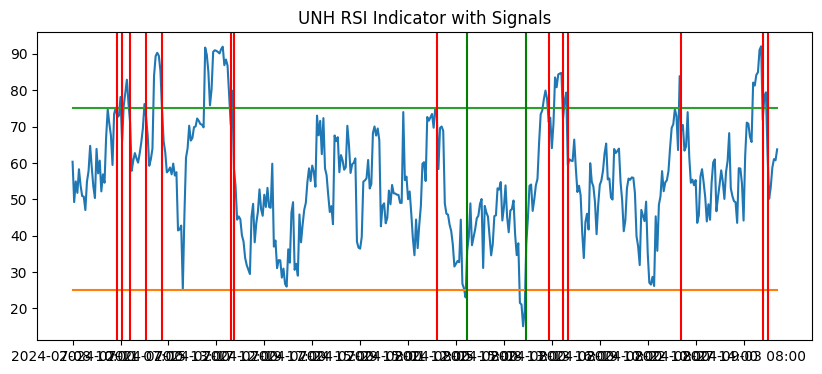

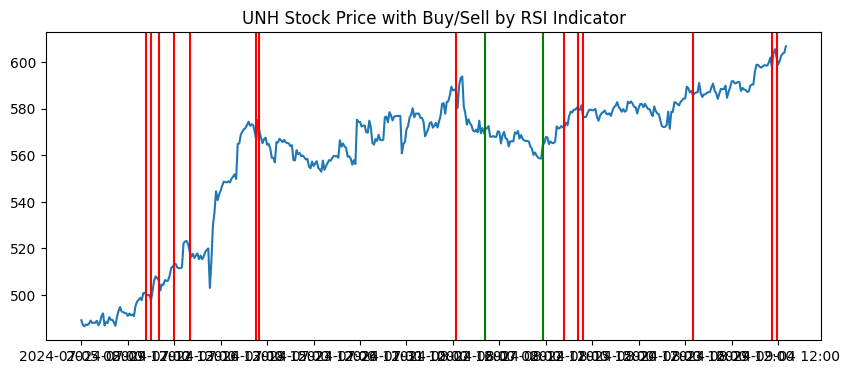

Transactions:  [['2024-07-10 17:00', 500, 'Sell'], ['2024-07-11 08:00', 497.56, 'Sell'], ['2024-07-11 13:00', 506.28, 'Sell'], ['2024-07-12 13:00', 513.0343, 'Sell'], ['2024-07-15 09:00', 518.65, 'Sell'], ['2024-07-18 08:00', 566.6, 'Sell'], ['2024-07-18 10:00', 570.43, 'Sell'], ['2024-08-02 19:00', 587.7, 'Sell'], ['2024-08-06 12:00', 571.455, 'Buy'], ['2024-08-12 09:00', 564.39, 'Buy'], ['2024-08-13 14:00', 572.35, 'Sell'], ['2024-08-14 15:00', 579.39, 'Sell'], ['2024-08-15 09:00', 576.63, 'Sell'], ['2024-08-26 13:00', 585.8401, 'Sell'], ['2024-09-04 08:00', 598.16, 'Sell'], ['2024-09-04 11:00', 602.075, 'Sell']]


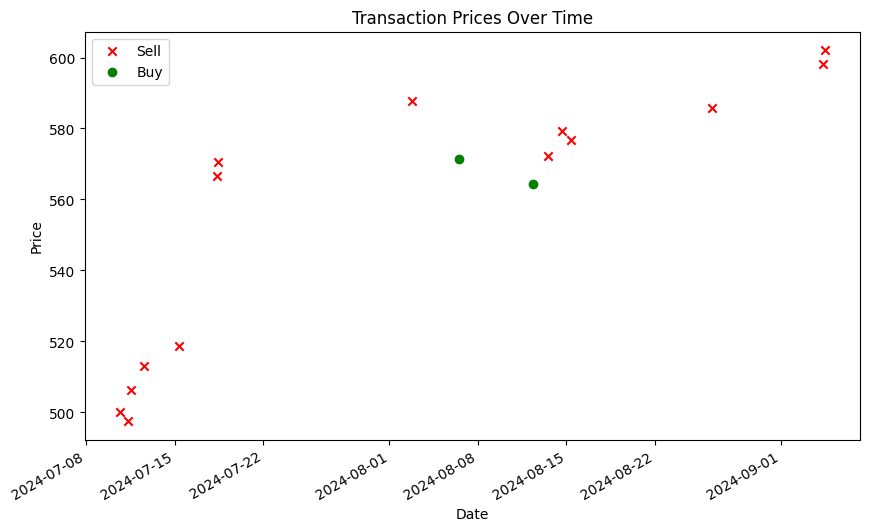

Running Simulation for RSI with UNH from 2024-07-04 to 2024-09-04
Number of Transactions:  16
Buys:  2 Sells:  14
Open Price, Close Price:  489.12 606.95
Beginning Cash and Shares:  500000.0 1022.2440300948642
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  800000.0 477.06733064470717
End Portfolio Value:  1089556.0163348052

Model Profit Percentage:  8.955601633480518
Market Change w/o trades 12.04510140660779

Model outperforms market by -3.0894997731272724 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for JNJ from 2024-07-04 to 2024-09-04
Number of Data Points: 527


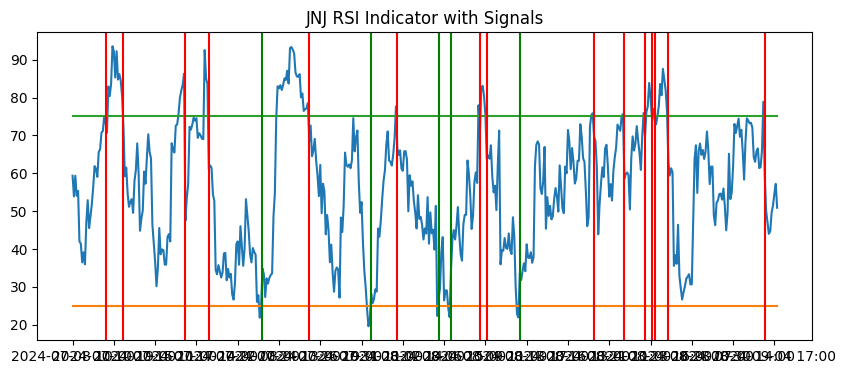

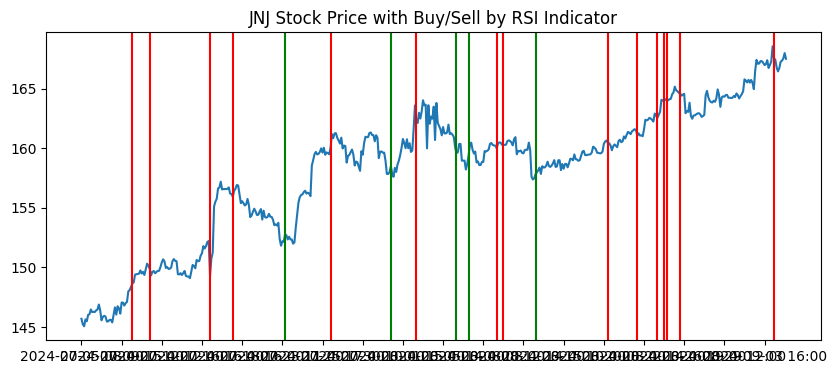

Transactions:  [['2024-07-10 13:00', 148.65, 'Sell'], ['2024-07-11 13:00', 149.87, 'Sell'], ['2024-07-17 06:00', 149.3, 'Sell'], ['2024-07-18 09:00', 155.94, 'Sell'], ['2024-07-23 13:00', 152.77, 'Buy'], ['2024-07-26 09:00', 160.085, 'Sell'], ['2024-07-31 18:00', 158.49, 'Buy'], ['2024-08-02 10:00', 162.245, 'Sell'], ['2024-08-06 11:00', 159.595, 'Buy'], ['2024-08-07 08:00', 159.4, 'Buy'], ['2024-08-08 18:00', 160, 'Sell'], ['2024-08-09 12:00', 160.3, 'Sell'], ['2024-08-13 12:00', 157.83, 'Buy'], ['2024-08-20 11:00', 160.46, 'Sell'], ['2024-08-22 09:00', 161.08, 'Sell'], ['2024-08-23 12:00', 162.55, 'Sell'], ['2024-08-23 17:00', 164, 'Sell'], ['2024-08-26 06:00', 164.02, 'Sell'], ['2024-08-26 16:00', 164.61, 'Sell'], ['2024-09-04 10:00', 167.585, 'Sell']]


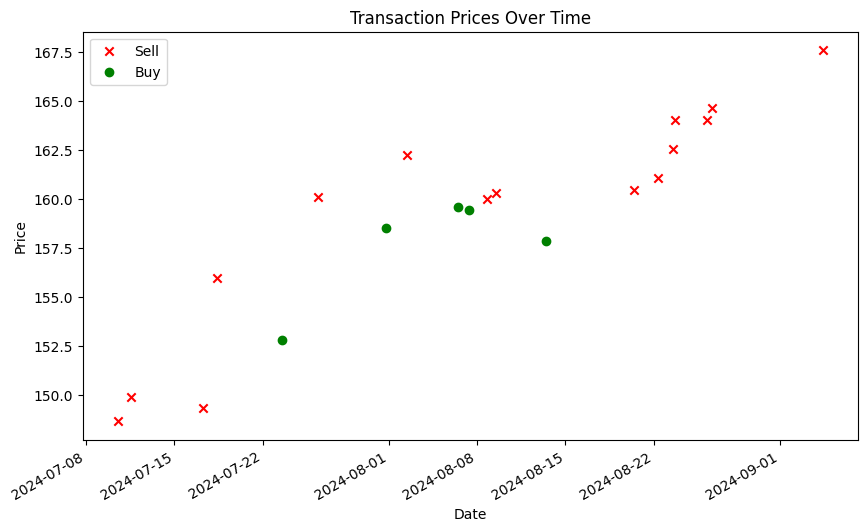

Running Simulation for RSI with JNJ from 2024-07-04 to 2024-09-04
Number of Transactions:  20
Buys:  5 Sells:  15
Open Price, Close Price:  145.69 167.52
Beginning Cash and Shares:  500000.0 3431.9445397762374
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  750000.0 1869.2756663321416
End Portfolio Value:  1063141.0596239604

Model Profit Percentage:  6.314105962396041
Market Change w/o trades 7.49193493033153

Model outperforms market by -1.177828967935489 %


Invest RSI for V from 2024-07-04 to 2024-09-04
Number of Data Points: 539


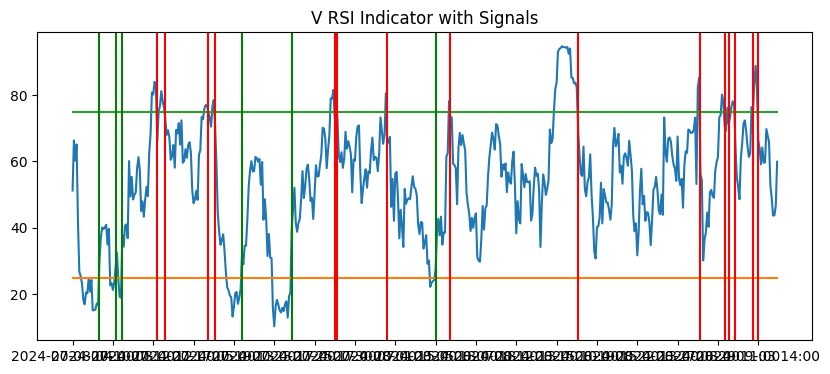

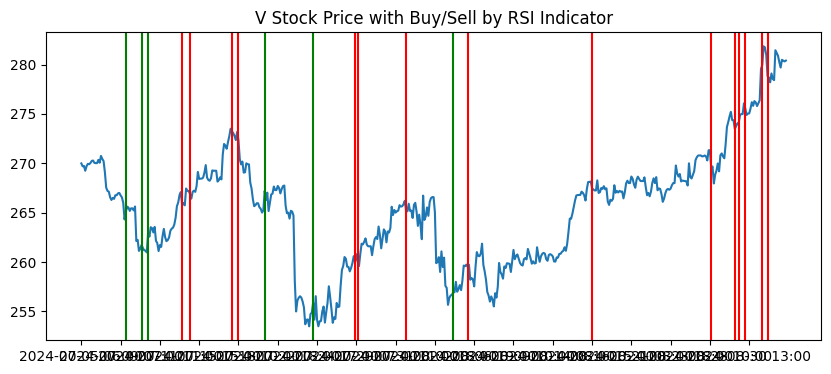

Transactions:  [['2024-07-09 11:00', 265.095, 'Buy'], ['2024-07-10 10:00', 261.735, 'Buy'], ['2024-07-10 15:00', 262.99, 'Buy'], ['2024-07-12 15:00', 265.76, 'Sell'], ['2024-07-15 08:00', 266.89, 'Sell'], ['2024-07-17 17:00', 273.25, 'Sell'], ['2024-07-18 10:00', 272.34, 'Sell'], ['2024-07-22 08:00', 267.2, 'Buy'], ['2024-07-24 14:00', 255.885, 'Buy'], ['2024-07-29 06:00', 260, 'Sell'], ['2024-07-29 08:00', 260.1, 'Sell'], ['2024-08-01 09:00', 265.19, 'Sell'], ['2024-08-05 18:00', 256.94, 'Buy'], ['2024-08-06 13:00', 259.52, 'Sell'], ['2024-08-16 15:00', 267.49, 'Sell'], ['2024-08-28 11:00', 269.5, 'Sell'], ['2024-08-29 16:00', 273.49, 'Sell'], ['2024-08-30 04:00', 274.11, 'Sell'], ['2024-08-30 10:00', 275.56, 'Sell'], ['2024-09-03 10:00', 279.97, 'Sell'], ['2024-09-03 14:00', 278.815, 'Sell']]


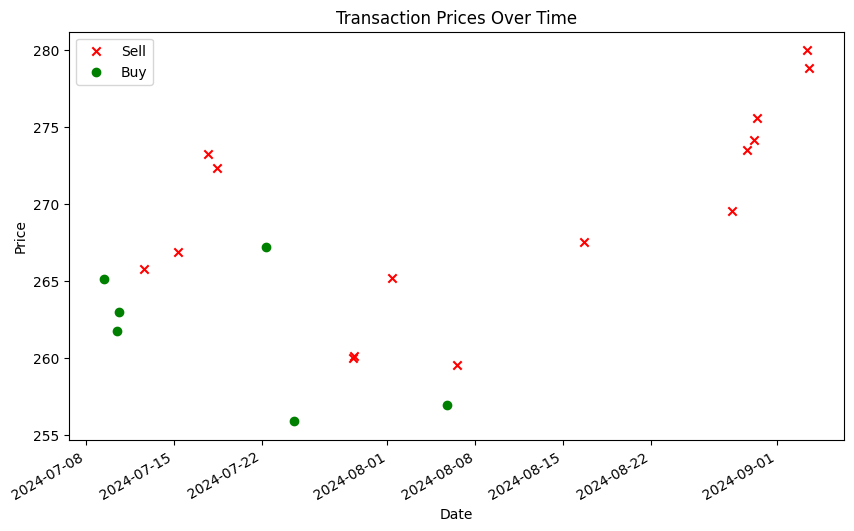

Running Simulation for RSI with V from 2024-07-04 to 2024-09-04
Number of Transactions:  21
Buys:  6 Sells:  15
Open Price, Close Price:  269.99 280.4
Beginning Cash and Shares:  500000.0 1851.9204414978333
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  725000.0 1032.9352838216143
End Portfolio Value:  1014635.0535835807

Model Profit Percentage:  1.463505358358065
Market Change w/o trades 1.9278491795992385

Model outperforms market by -0.46434382124117346 %


Invest RSI for WMT from 2024-07-04 to 2024-09-04
Number of Data Points: 658


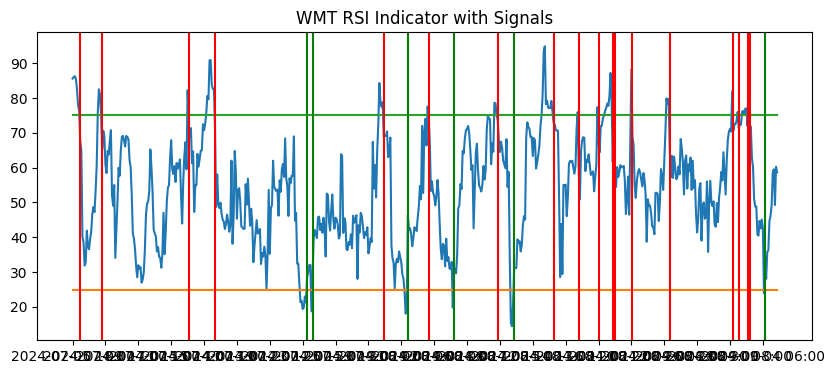

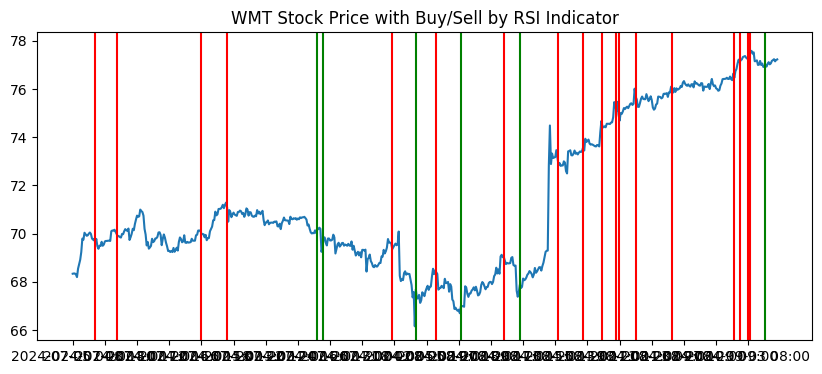

Transactions:  [['2024-07-08 09:00', 69.62, 'Sell'], ['2024-07-09 14:00', 69.985, 'Sell'], ['2024-07-16 15:00', 70.01, 'Sell'], ['2024-07-18 07:00', 71.08, 'Sell'], ['2024-07-25 19:00', 70.1698, 'Buy'], ['2024-07-26 10:00', 69.45, 'Buy'], ['2024-08-01 19:00', 69.36, 'Sell'], ['2024-08-05 09:00', 67.69, 'Buy'], ['2024-08-06 13:00', 68.405, 'Sell'], ['2024-08-08 04:00', 67, 'Buy'], ['2024-08-12 13:00', 69.04, 'Sell'], ['2024-08-13 12:00', 67.8882, 'Buy'], ['2024-08-15 16:00', 72.85, 'Sell'], ['2024-08-19 07:00', 73.59, 'Sell'], ['2024-08-20 11:00', 74.4615, 'Sell'], ['2024-08-21 08:00', 75.09, 'Sell'], ['2024-08-21 10:00', 74.94, 'Sell'], ['2024-08-22 10:00', 75.67, 'Sell'], ['2024-08-26 13:00', 75.8501, 'Sell'], ['2024-08-30 11:00', 76.47, 'Sell'], ['2024-08-30 16:00', 77.12, 'Sell'], ['2024-09-03 08:00', 77.25, 'Sell'], ['2024-09-03 10:00', 77.51, 'Sell'], ['2024-09-04 08:00', 77.02, 'Buy']]


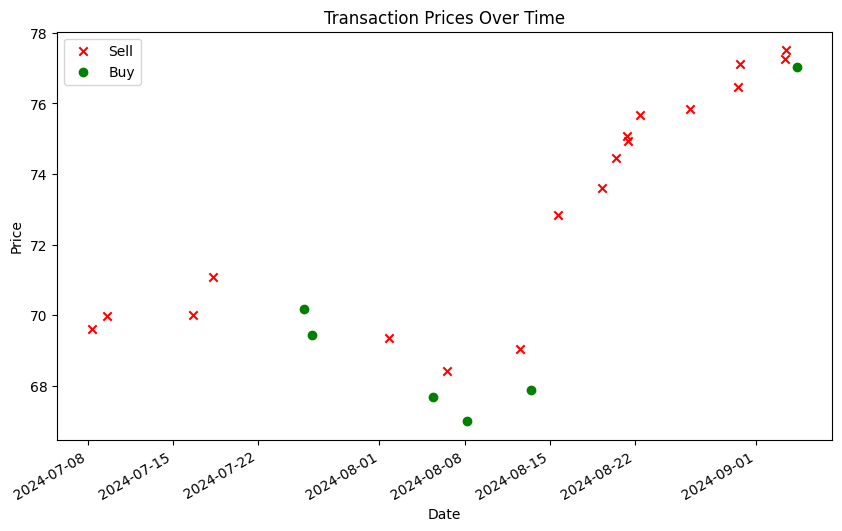

Running Simulation for RSI with WMT from 2024-07-04 to 2024-09-04
Number of Transactions:  24
Buys:  6 Sells:  18
Open Price, Close Price:  68.34 77.23
Beginning Cash and Shares:  500000.0 7316.359379572724
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  800000.0 3312.3727322477635
End Portfolio Value:  1055814.5461114948

Model Profit Percentage:  5.581454611149477
Market Change w/o trades 6.504243488440152

Model outperforms market by -0.9227888772906754 %


Invest RSI for XOM from 2024-07-04 to 2024-09-04
Number of Data Points: 654


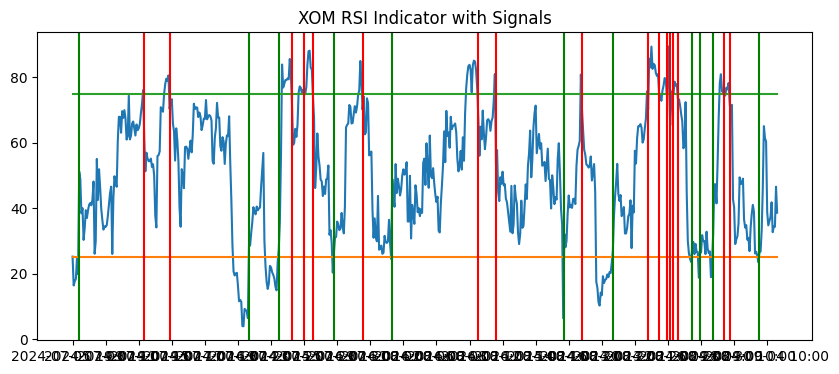

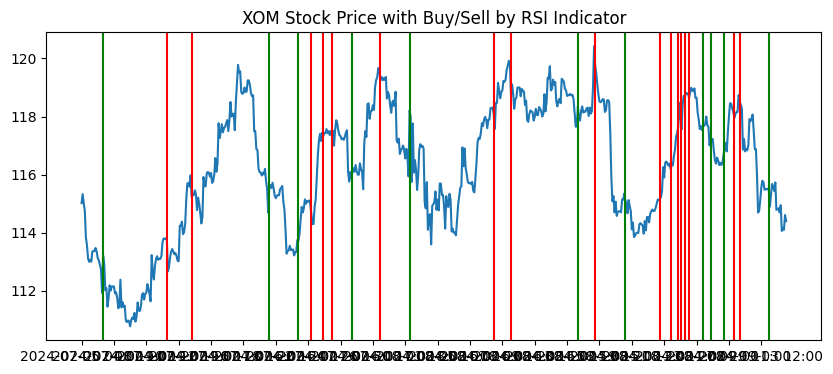

Transactions:  [['2024-07-08 09:00', 113.21, 'Buy'], ['2024-07-12 08:00', 113.8202, 'Sell'], ['2024-07-15 15:00', 115.24, 'Sell'], ['2024-07-22 10:00', 115.635, 'Buy'], ['2024-07-24 08:00', 113.72, 'Buy'], ['2024-07-25 04:00', 114.64, 'Sell'], ['2024-07-25 16:00', 117.34, 'Sell'], ['2024-07-26 08:00', 117.37, 'Sell'], ['2024-07-29 13:00', 116.09, 'Buy'], ['2024-07-31 09:00', 119.26, 'Sell'], ['2024-08-02 06:00', 118.21, 'Buy'], ['2024-08-09 08:00', 118.09, 'Sell'], ['2024-08-12 09:00', 118.7501, 'Sell'], ['2024-08-16 09:00', 118.355, 'Buy'], ['2024-08-19 11:00', 119.74, 'Sell'], ['2024-08-21 07:00', 115.11, 'Buy'], ['2024-08-23 07:00', 115.15, 'Sell'], ['2024-08-23 17:00', 116.2, 'Sell'], ['2024-08-26 08:00', 117.64, 'Sell'], ['2024-08-26 11:00', 117.56, 'Sell'], ['2024-08-26 14:00', 118.67, 'Sell'], ['2024-08-26 18:00', 118.65, 'Sell'], ['2024-08-27 15:00', 117.7, 'Buy'], ['2024-08-28 08:00', 117.21, 'Buy'], ['2024-08-29 06:00', 116.69, 'Buy'], ['2024-08-29 16:00', 117.96, 'Sell'], ['

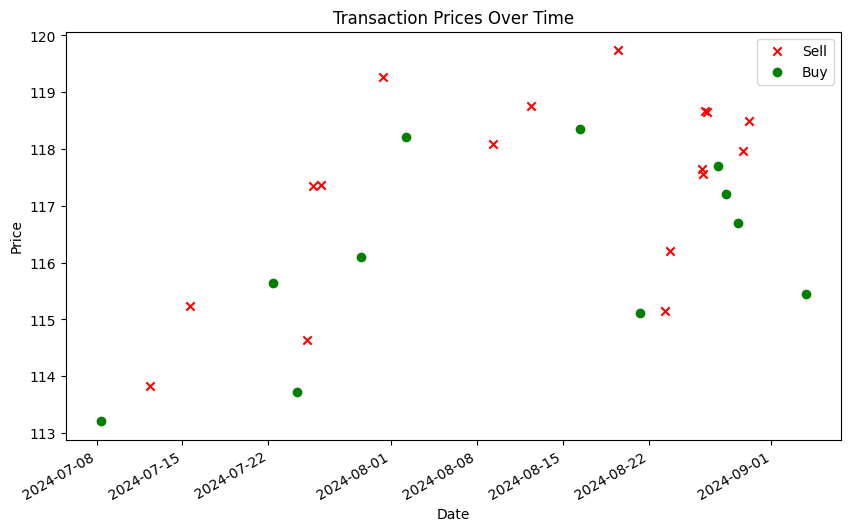

Running Simulation for RSI with XOM from 2024-07-04 to 2024-09-04
Number of Transactions:  28
Buys:  11 Sells:  17
Open Price, Close Price:  115.02 114.4
Beginning Cash and Shares:  500000.0 4347.0700747696055
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  650000.0 3092.6097031600366
End Portfolio Value:  1003794.5500415082

Model Profit Percentage:  0.37945500415081623
Market Change w/o trades -0.26951834463571134

Model outperforms market by 0.6489733487865276 %


Invest RSI for PG from 2024-07-04 to 2024-09-04
Number of Data Points: 498


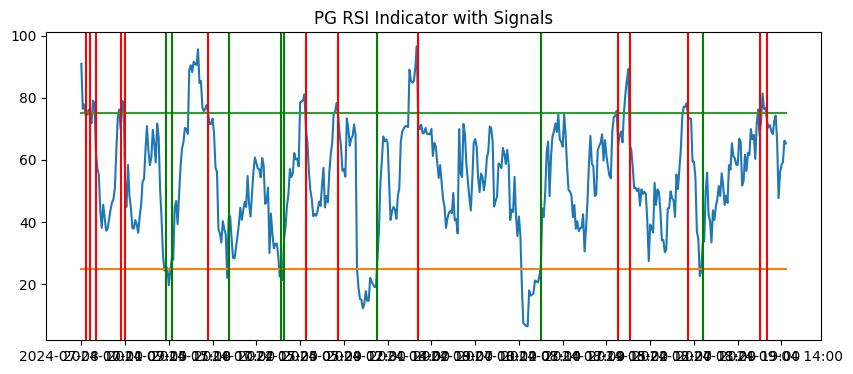

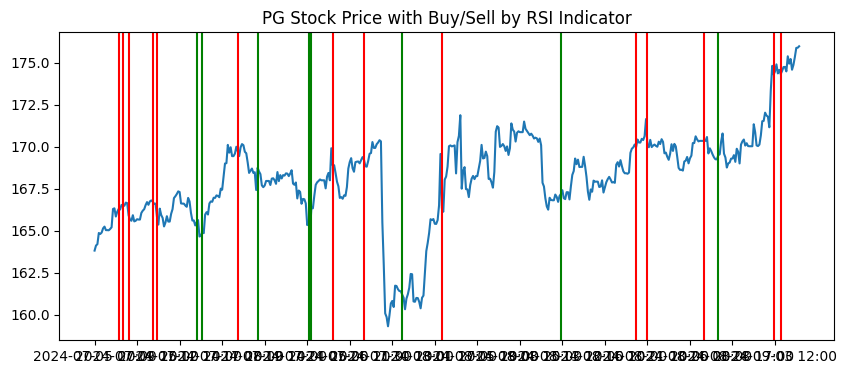

Transactions:  [['2024-07-08 13:00', 166.295, 'Sell'], ['2024-07-08 16:00', 166.52, 'Sell'], ['2024-07-09 09:00', 165.915, 'Sell'], ['2024-07-10 17:00', 166.73, 'Sell'], ['2024-07-11 09:00', 165.83, 'Sell'], ['2024-07-15 13:00', 165.5, 'Buy'], ['2024-07-16 06:00', 164.9, 'Buy'], ['2024-07-18 07:00', 169.74, 'Sell'], ['2024-07-19 09:00', 168.75, 'Buy'], ['2024-07-24 07:00', 165.49, 'Buy'], ['2024-07-24 09:00', 166.42, 'Buy'], ['2024-07-25 10:00', 168.885, 'Sell'], ['2024-07-29 08:00', 169.25, 'Sell'], ['2024-07-31 07:00', 161.2, 'Buy'], ['2024-08-02 10:00', 166.34, 'Sell'], ['2024-08-13 11:00', 167.19, 'Buy'], ['2024-08-20 14:00', 169.97, 'Sell'], ['2024-08-21 10:00', 170.07, 'Sell'], ['2024-08-26 18:00', 170.35, 'Sell'], ['2024-08-27 17:00', 169.5, 'Buy'], ['2024-09-03 11:00', 174.3, 'Sell'], ['2024-09-03 16:00', 174.33, 'Sell']]


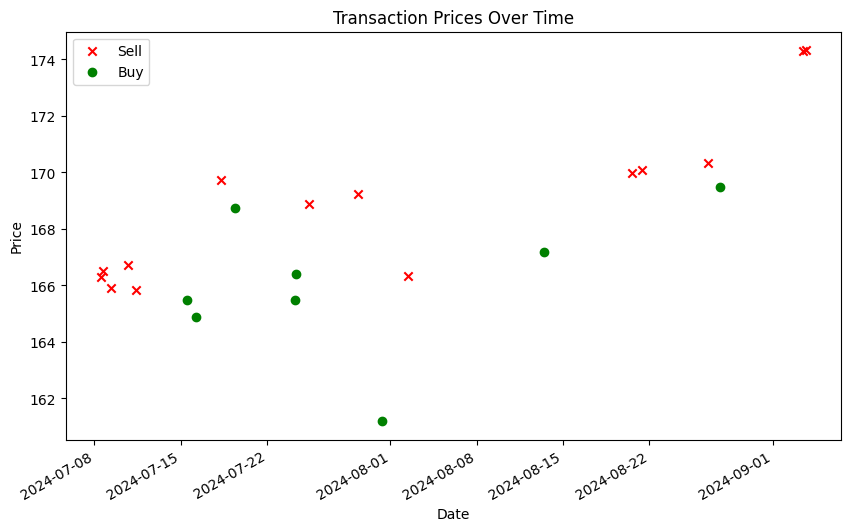

Running Simulation for RSI with PG from 2024-07-04 to 2024-09-04
Number of Transactions:  22
Buys:  8 Sells:  14
Open Price, Close Price:  163.81 175.9872
Beginning Cash and Shares:  500000.0 3052.3167083816616
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  650000.0 2183.6856778508577
End Portfolio Value:  1034300.7281250744

Model Profit Percentage:  3.4300728125074413
Market Change w/o trades 3.7168671021305166

Model outperforms market by -0.2867942896230753 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for JPM from 2024-07-04 to 2024-09-04
Number of Data Points: 580


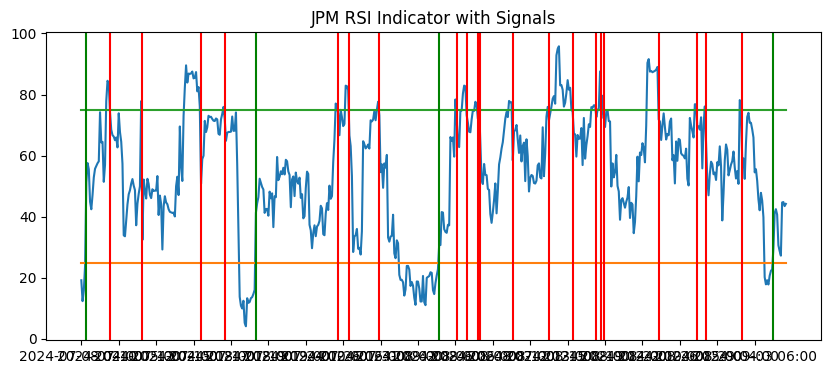

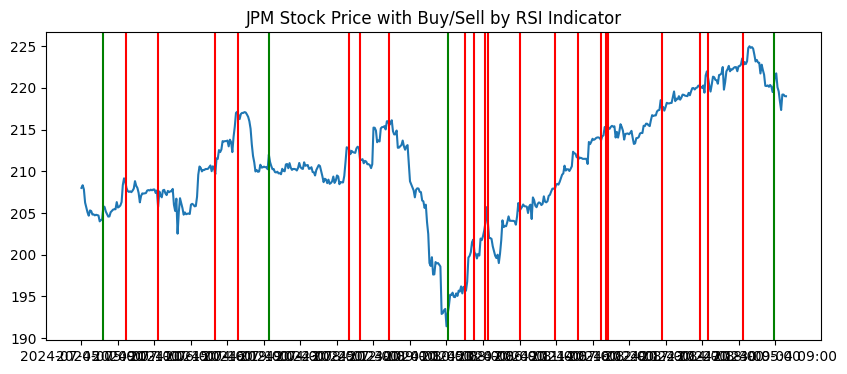

Transactions:  [['2024-07-08 09:00', 205.8, 'Buy'], ['2024-07-09 14:00', 208, 'Sell'], ['2024-07-11 09:00', 205.73, 'Sell'], ['2024-07-16 09:00', 209.65, 'Sell'], ['2024-07-17 13:00', 216.755, 'Sell'], ['2024-07-19 09:00', 212, 'Buy'], ['2024-07-26 12:00', 212.6338, 'Sell'], ['2024-07-29 09:00', 211.33, 'Sell'], ['2024-07-31 08:00', 215.55, 'Sell'], ['2024-08-05 09:00', 192.92, 'Buy'], ['2024-08-06 07:00', 195.99, 'Sell'], ['2024-08-06 15:00', 200.24, 'Sell'], ['2024-08-07 08:00', 203.86, 'Sell'], ['2024-08-07 10:00', 203.79, 'Sell'], ['2024-08-09 11:00', 205.24, 'Sell'], ['2024-08-13 17:00', 207.84, 'Sell'], ['2024-08-15 12:00', 211.91, 'Sell'], ['2024-08-16 19:00', 213.72, 'Sell'], ['2024-08-19 11:00', 215.07, 'Sell'], ['2024-08-19 13:00', 215.15, 'Sell'], ['2024-08-23 11:00', 217.5474, 'Sell'], ['2024-08-27 16:00', 220.15, 'Sell'], ['2024-08-28 11:00', 221.175, 'Sell'], ['2024-08-30 11:00', 222.7572, 'Sell'], ['2024-09-04 08:00', 220.3363, 'Buy']]


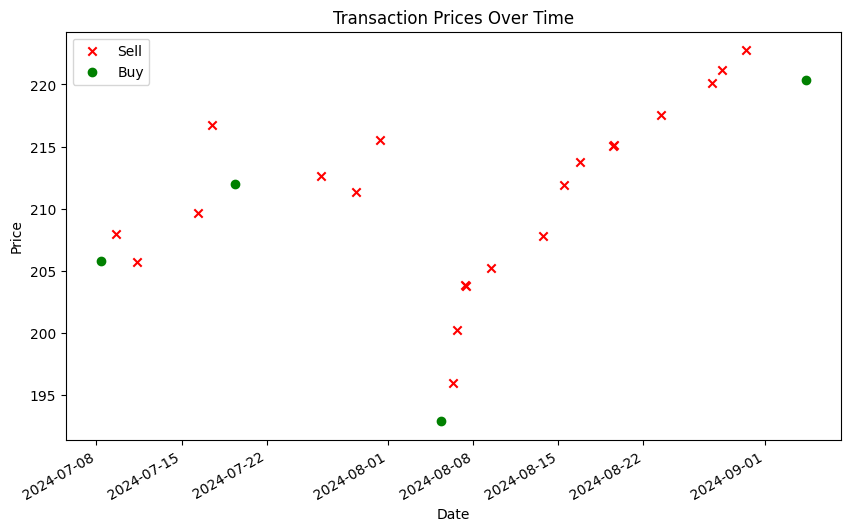

Running Simulation for RSI with JPM from 2024-07-04 to 2024-09-04
Number of Transactions:  25
Buys:  4 Sells:  21
Open Price, Close Price:  208.01 219
Beginning Cash and Shares:  500000.0 2403.7305898754867
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  925000.0 397.0961747438485
End Portfolio Value:  1011964.0622689028

Model Profit Percentage:  1.1964062268902782
Market Change w/o trades 2.641699918273162

Model outperforms market by -1.4452936913828838 %


Invest RSI for MA from 2024-07-04 to 2024-09-04
Number of Data Points: 431


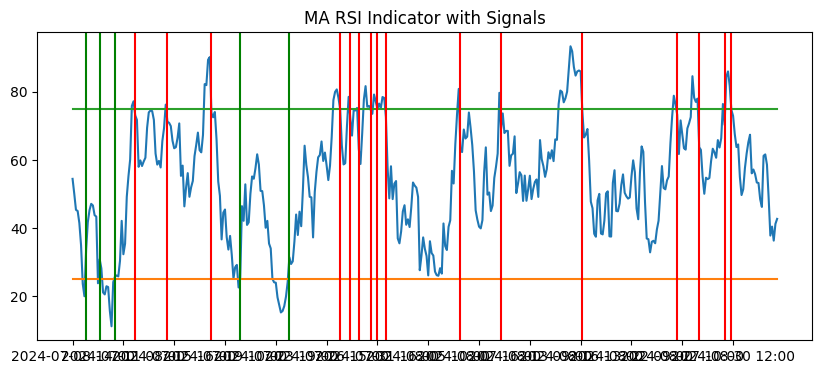

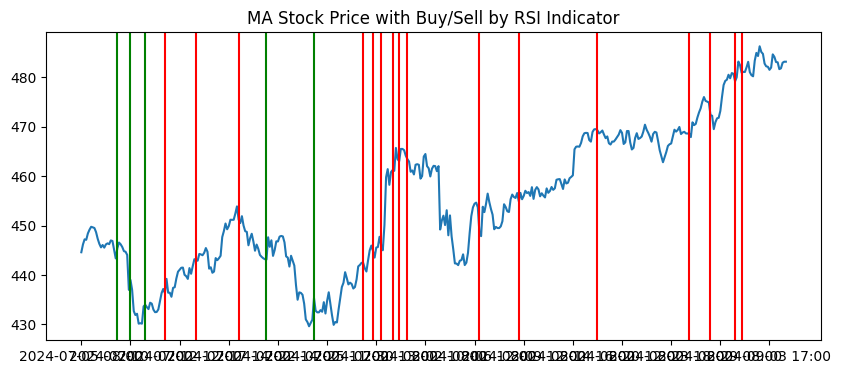

Transactions:  [['2024-07-09 11:00', 445.44, 'Buy'], ['2024-07-10 07:00', 439, 'Buy'], ['2024-07-10 16:00', 433.98, 'Buy'], ['2024-07-11 15:00', 436.36, 'Sell'], ['2024-07-15 12:00', 442.91, 'Sell'], ['2024-07-18 11:00', 451.2, 'Sell'], ['2024-07-22 04:00', 443.12, 'Buy'], ['2024-07-24 14:00', 435.36, 'Buy'], ['2024-07-29 14:00', 442.4818, 'Sell'], ['2024-07-30 11:00', 444.87, 'Sell'], ['2024-07-30 16:00', 446, 'Sell'], ['2024-07-31 12:00', 461.23, 'Sell'], ['2024-07-31 16:00', 463.01, 'Sell'], ['2024-08-01 10:00', 463.45, 'Sell'], ['2024-08-06 15:00', 448.29, 'Sell'], ['2024-08-09 09:00', 454.895, 'Sell'], ['2024-08-16 14:00', 469.27, 'Sell'], ['2024-08-27 07:00', 468.64, 'Sell'], ['2024-08-28 11:00', 472.36, 'Sell'], ['2024-08-29 17:00', 479.17, 'Sell'], ['2024-08-30 11:00', 480.895, 'Sell']]


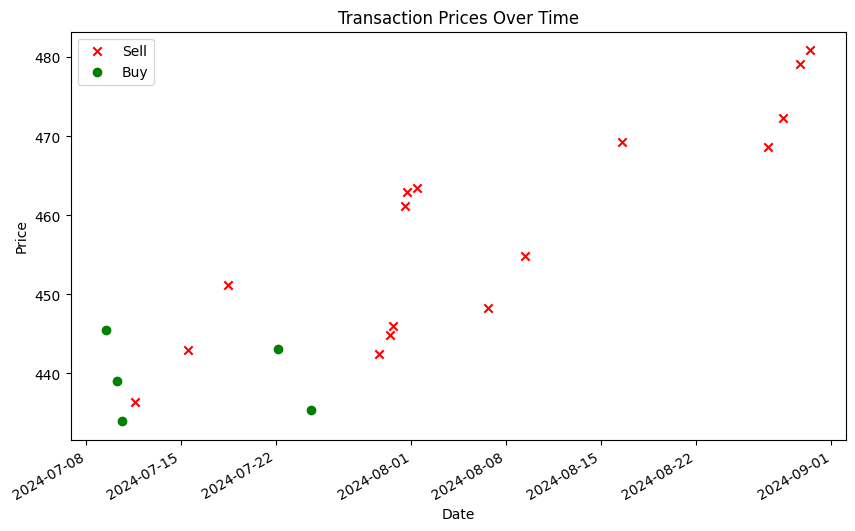

Running Simulation for RSI with MA from 2024-07-04 to 2024-09-04
Number of Transactions:  21
Buys:  5 Sells:  16
Open Price, Close Price:  444.6 483.14
Beginning Cash and Shares:  500000.0 1124.6063877642825
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  775000.0 534.6605230341945
End Portfolio Value:  1033315.8850987407

Model Profit Percentage:  3.331588509874069
Market Change w/o trades 4.334233018443541

Model outperforms market by -1.002644508569472 %


Invest RSI for LLY from 2024-07-04 to 2024-09-04
Number of Data Points: 615


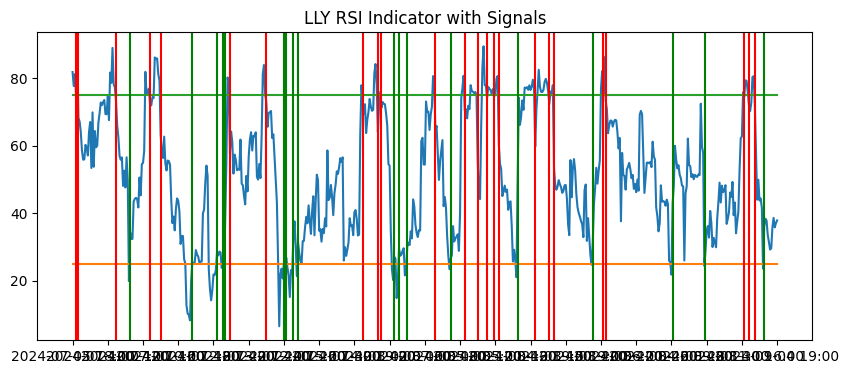

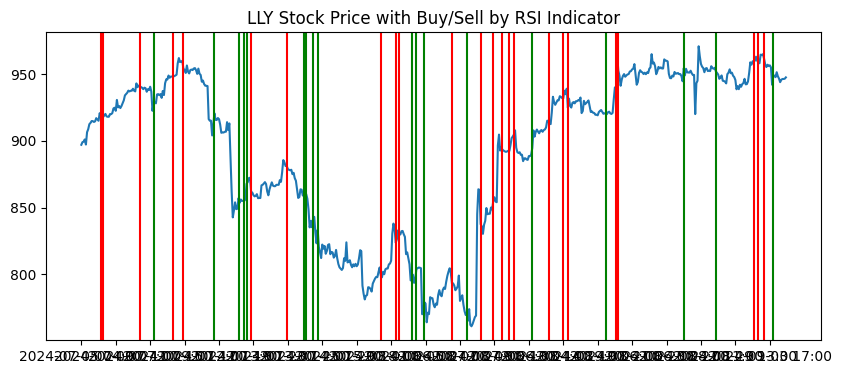

Transactions:  [['2024-07-08 09:00', 918.24, 'Sell'], ['2024-07-08 11:00', 917.8, 'Sell'], ['2024-07-10 14:00', 940.79, 'Sell'], ['2024-07-11 12:00', 928.51, 'Buy'], ['2024-07-12 16:00', 948.4, 'Sell'], ['2024-07-15 11:00', 953.71, 'Sell'], ['2024-07-17 09:00', 920.6, 'Buy'], ['2024-07-18 16:00', 856.99, 'Buy'], ['2024-07-19 05:00', 855, 'Buy'], ['2024-07-19 07:00', 867.8, 'Buy'], ['2024-07-19 11:00', 861.4475, 'Sell'], ['2024-07-23 13:00', 881.15, 'Sell'], ['2024-07-24 15:00', 860.57, 'Buy'], ['2024-07-24 17:00', 860, 'Buy'], ['2024-07-25 07:00', 842, 'Buy'], ['2024-07-25 11:00', 833.27, 'Buy'], ['2024-07-31 11:00', 798.99, 'Sell'], ['2024-08-01 10:00', 823.6, 'Sell'], ['2024-08-01 13:00', 830.07, 'Sell'], ['2024-08-02 11:00', 797.5, 'Buy'], ['2024-08-02 15:00', 803.9, 'Buy'], ['2024-08-05 06:00', 779, 'Buy'], ['2024-08-06 15:00', 792.9, 'Sell'], ['2024-08-07 13:00', 771, 'Buy'], ['2024-08-08 09:00', 837.56, 'Sell'], ['2024-08-09 04:00', 855, 'Sell'], ['2024-08-09 13:00', 893.345, 'Se

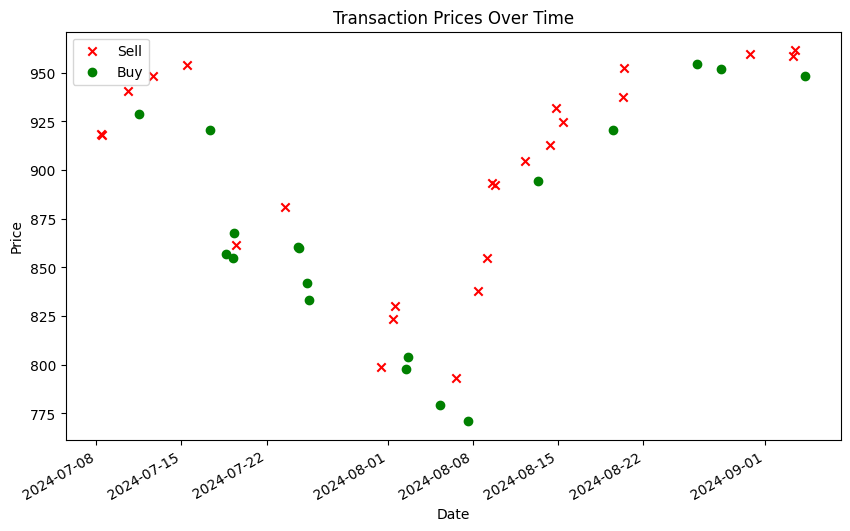

Running Simulation for RSI with LLY from 2024-07-04 to 2024-09-04
Number of Transactions:  42
Buys:  18 Sells:  24
Open Price, Close Price:  897 947.49
Beginning Cash and Shares:  500000.0 557.4136008918617
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  650000.0 408.1219442546754
End Portfolio Value:  1036691.4609618625

Model Profit Percentage:  3.6691460961862465
Market Change w/o trades 2.8143812709030103

Model outperforms market by 0.8547648252832363 %


Invest RSI for HD from 2024-07-04 to 2024-09-04
Number of Data Points: 505


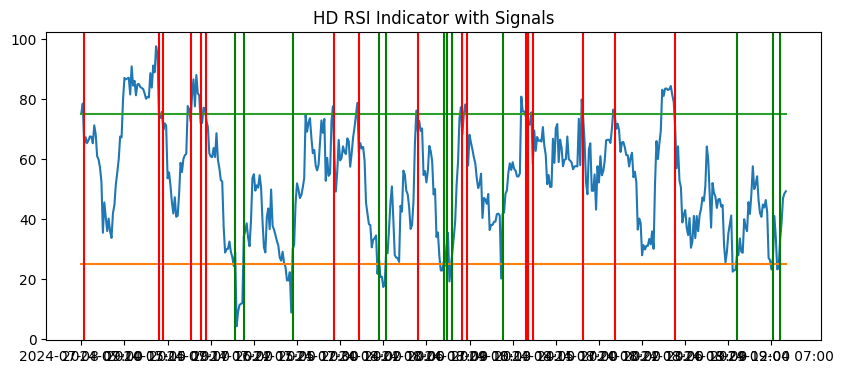

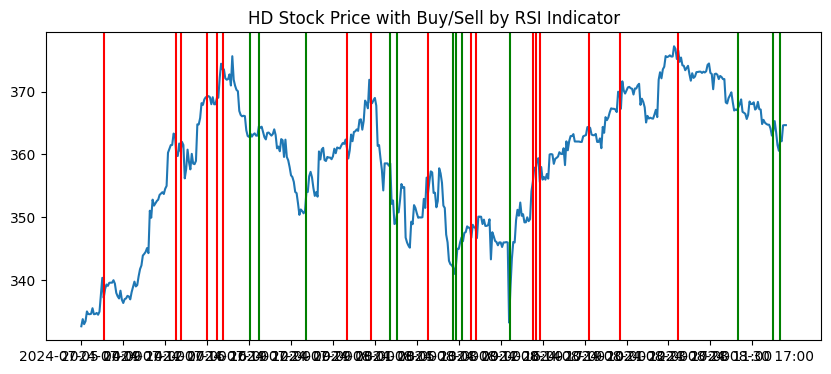

Transactions:  [['2024-07-08 11:00', 337.195, 'Sell'], ['2024-07-12 15:00', 359.77, 'Sell'], ['2024-07-12 19:00', 360.47, 'Sell'], ['2024-07-16 16:00', 369.12, 'Sell'], ['2024-07-17 09:00', 369.04, 'Sell'], ['2024-07-17 13:00', 373.505, 'Sell'], ['2024-07-19 13:00', 363.32, 'Buy'], ['2024-07-22 08:00', 364.51, 'Buy'], ['2024-07-25 09:00', 353.99, 'Buy'], ['2024-07-30 10:00', 361.049, 'Sell'], ['2024-07-31 15:00', 368.24, 'Sell'], ['2024-08-01 19:00', 358.58, 'Buy'], ['2024-08-02 12:00', 350.8724, 'Buy'], ['2024-08-06 11:00', 353.87, 'Sell'], ['2024-08-07 17:00', 342, 'Buy'], ['2024-08-08 05:00', 342.4, 'Buy'], ['2024-08-08 11:00', 346.815, 'Buy'], ['2024-08-08 18:00', 346.7539, 'Sell'], ['2024-08-09 08:00', 348.3, 'Sell'], ['2024-08-13 07:00', 338.9, 'Buy'], ['2024-08-14 10:00', 355.655, 'Sell'], ['2024-08-14 12:00', 357.55, 'Sell'], ['2024-08-14 15:00', 355.61, 'Sell'], ['2024-08-19 13:00', 364.39, 'Sell'], ['2024-08-21 07:00', 369.77, 'Sell'], ['2024-08-26 12:00', 376.54, 'Sell'], ['

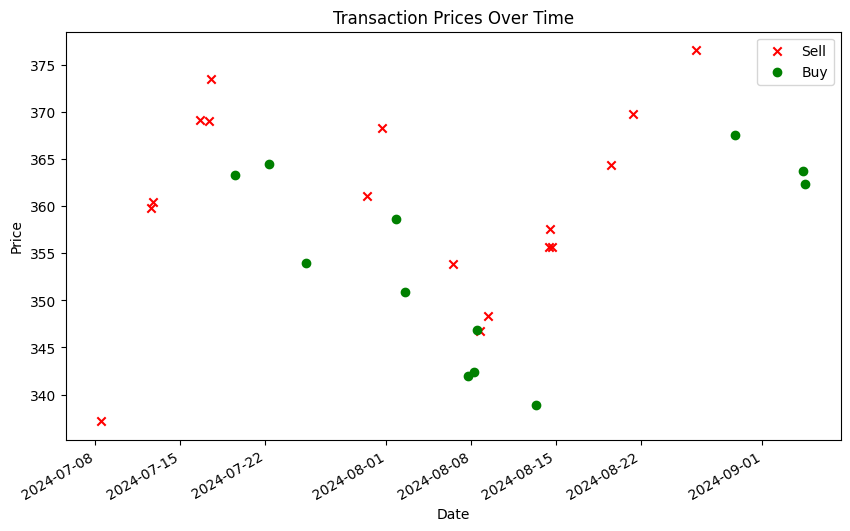

Running Simulation for RSI with HD from 2024-07-04 to 2024-09-04
Number of Transactions:  29
Buys:  12 Sells:  17
Open Price, Close Price:  332.66 364.67
Beginning Cash and Shares:  500000.0 1503.0361329886368
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  625000.0 1169.5684328270086
End Portfolio Value:  1051506.5203990252

Model Profit Percentage:  5.150652039902518
Market Change w/o trades 4.811218661696625

Model outperforms market by 0.3394333782058929 %


Invest RSI for CVX from 2024-07-04 to 2024-09-04
Number of Data Points: 591


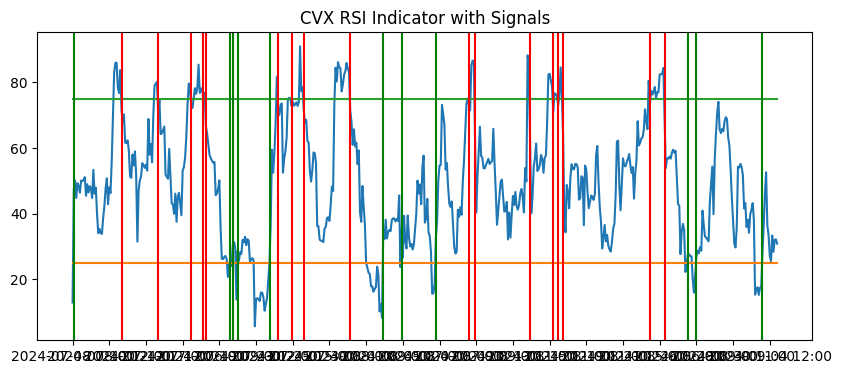

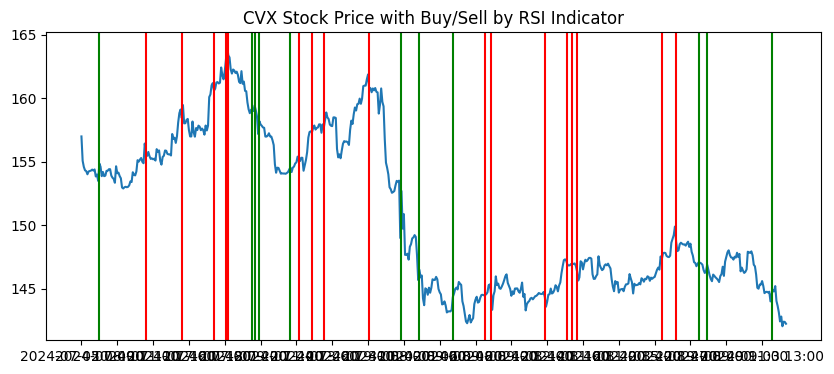

Transactions:  [['2024-07-08 09:00', 154.865, 'Buy'], ['2024-07-11 11:00', 155.63, 'Sell'], ['2024-07-15 13:00', 158.455, 'Sell'], ['2024-07-17 13:00', 160.61, 'Sell'], ['2024-07-18 10:00', 163.05, 'Sell'], ['2024-07-18 12:00', 163.385, 'Sell'], ['2024-07-19 18:00', 159.15, 'Buy'], ['2024-07-22 04:00', 159.45, 'Buy'], ['2024-07-22 10:00', 158.2, 'Buy'], ['2024-07-24 08:00', 154.55, 'Buy'], ['2024-07-24 15:00', 155.06, 'Sell'], ['2024-07-25 14:00', 157.32, 'Sell'], ['2024-07-26 10:00', 157.71, 'Sell'], ['2024-07-31 09:00', 160.715, 'Sell'], ['2024-08-02 07:00', 152.7, 'Buy'], ['2024-08-05 06:00', 146.5, 'Buy'], ['2024-08-07 04:00', 144.36, 'Buy'], ['2024-08-08 17:00', 144.5015, 'Sell'], ['2024-08-09 08:00', 144.62, 'Sell'], ['2024-08-14 09:00', 144.37, 'Sell'], ['2024-08-15 14:00', 146.89, 'Sell'], ['2024-08-15 18:00', 146.9441, 'Sell'], ['2024-08-16 06:00', 146.39, 'Sell'], ['2024-08-23 11:00', 147.32, 'Sell'], ['2024-08-26 10:00', 148.72, 'Sell'], ['2024-08-27 16:00', 147.1, 'Buy'], [

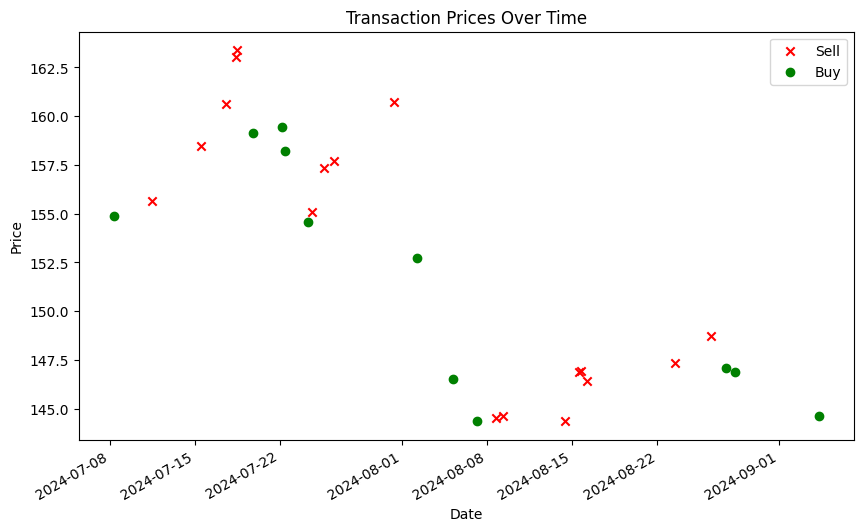

Running Simulation for RSI with CVX from 2024-07-04 to 2024-09-04
Number of Transactions:  28
Buys:  11 Sells:  17
Open Price, Close Price:  157 142.25
Beginning Cash and Shares:  500000.0 3184.7133757961783
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  650000.0 2217.81185669702
End Portfolio Value:  965483.7366151512

Model Profit Percentage:  -3.4516263384848833
Market Change w/o trades -4.697452229299363

Model outperforms market by 1.2458258908144795 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for MRK from 2024-07-04 to 2024-09-04
Number of Data Points: 544


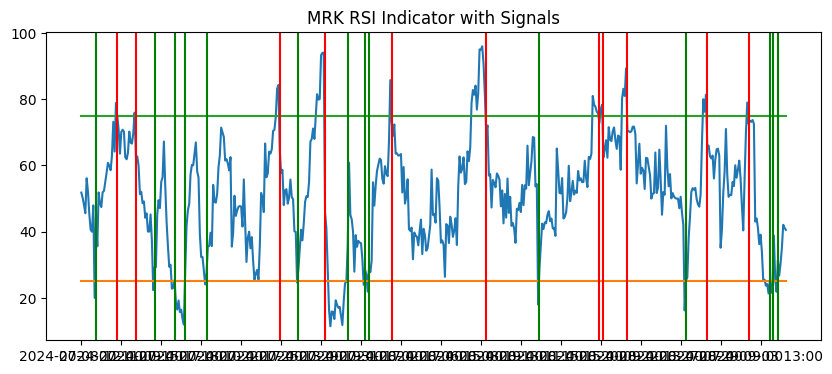

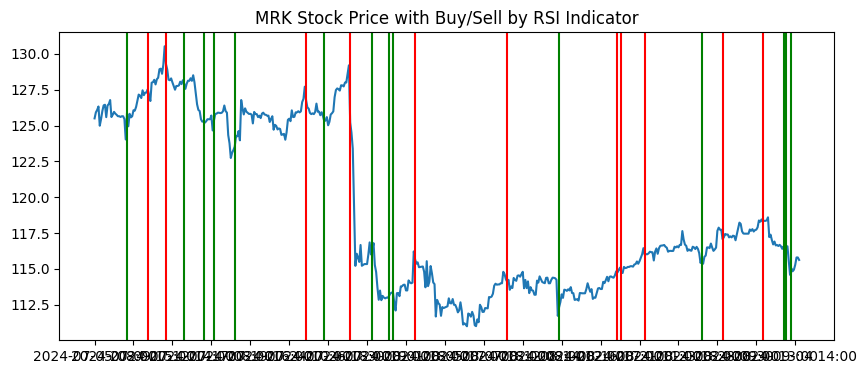

Transactions:  [['2024-07-09 10:00', 125.88, 'Buy'], ['2024-07-10 18:00', 127.5312, 'Sell'], ['2024-07-12 09:00', 129.3, 'Sell'], ['2024-07-15 12:00', 127.94, 'Buy'], ['2024-07-16 17:00', 125.3, 'Buy'], ['2024-07-17 10:00', 125.35, 'Buy'], ['2024-07-18 14:00', 123.53, 'Buy'], ['2024-07-25 12:00', 126.7765, 'Sell'], ['2024-07-26 15:00', 125.31, 'Buy'], ['2024-07-30 06:00', 125.22, 'Sell'], ['2024-07-31 07:00', 116.3, 'Buy'], ['2024-08-01 04:00', 113.13, 'Buy'], ['2024-08-01 08:00', 113.35, 'Buy'], ['2024-08-02 10:00', 115.68, 'Sell'], ['2024-08-09 07:00', 114.1, 'Sell'], ['2024-08-14 10:00', 112.325, 'Buy'], ['2024-08-20 08:00', 114.75, 'Sell'], ['2024-08-20 11:00', 114.72, 'Sell'], ['2024-08-21 15:00', 115.99, 'Sell'], ['2024-08-27 11:00', 115.62, 'Buy'], ['2024-08-28 13:00', 117.08, 'Sell'], ['2024-08-30 19:00', 118.29, 'Sell'], ['2024-09-04 04:00', 116.57, 'Buy'], ['2024-09-04 07:00', 116.52, 'Buy'], ['2024-09-04 11:00', 115.045, 'Buy']]


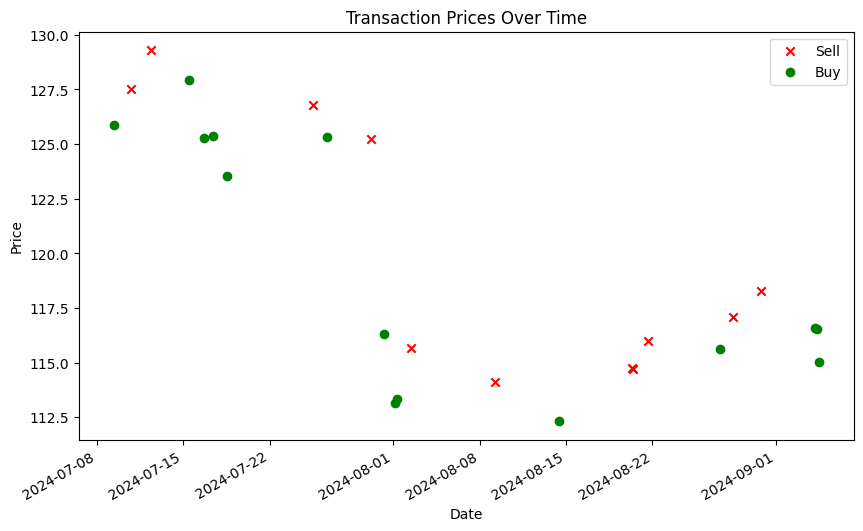

Running Simulation for RSI with MRK from 2024-07-04 to 2024-09-04
Number of Transactions:  25
Buys:  14 Sells:  11
Open Price, Close Price:  125.5 115.6265
Beginning Cash and Shares:  500000.0 3984.06374501992
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  425000.0 4622.896931183962
End Portfolio Value:  959529.3920135424

Model Profit Percentage:  -4.047060798645765
Market Change w/o trades -3.933665338645421

Model outperforms market by -0.11339546000034373 %


Invest RSI for PEP from 2024-07-04 to 2024-09-04
Number of Data Points: 530


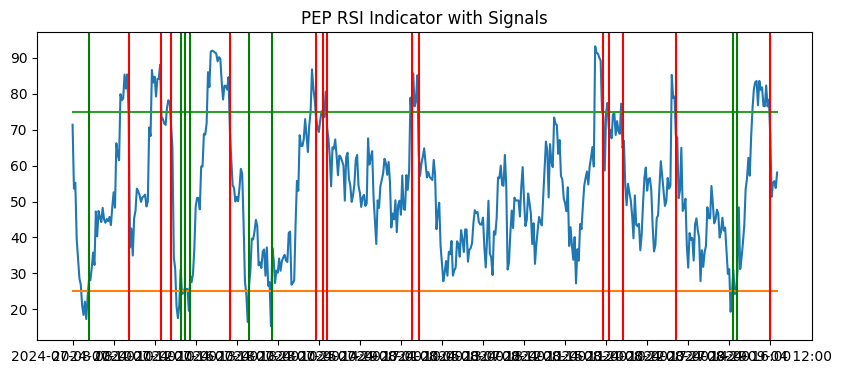

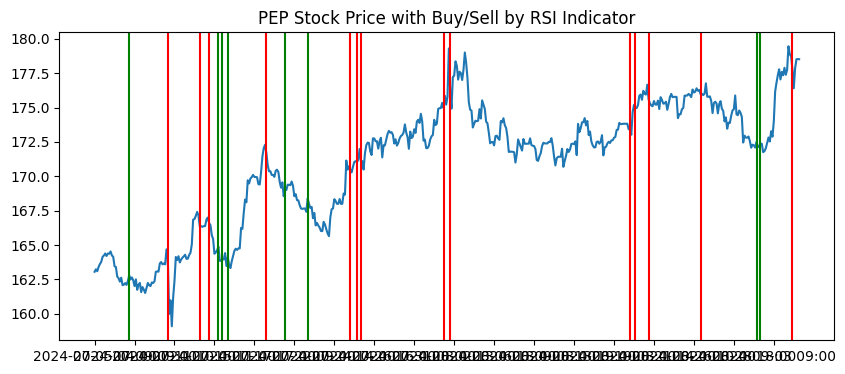

Transactions:  [['2024-07-09 04:00', 162.8, 'Buy'], ['2024-07-11 05:00', 164, 'Sell'], ['2024-07-12 15:00', 166.36, 'Sell'], ['2024-07-15 07:00', 166.61, 'Sell'], ['2024-07-15 14:00', 164.8905, 'Buy'], ['2024-07-15 17:00', 164, 'Buy'], ['2024-07-16 09:00', 164.11, 'Buy'], ['2024-07-18 13:00', 171.693, 'Sell'], ['2024-07-19 13:00', 169.115, 'Buy'], ['2024-07-23 06:00', 168.4, 'Buy'], ['2024-07-25 12:00', 170.495, 'Sell'], ['2024-07-25 17:00', 171.02, 'Sell'], ['2024-07-26 04:00', 171.07, 'Sell'], ['2024-08-01 18:00', 174.96, 'Sell'], ['2024-08-02 10:00', 176.16, 'Sell'], ['2024-08-20 08:00', 173.49, 'Sell'], ['2024-08-20 12:00', 174.98, 'Sell'], ['2024-08-21 10:00', 175.5722, 'Sell'], ['2024-08-26 15:00', 175.97, 'Sell'], ['2024-08-30 04:00', 172.51, 'Buy'], ['2024-08-30 09:00', 172.39, 'Buy'], ['2024-09-04 12:00', 177.75, 'Sell']]


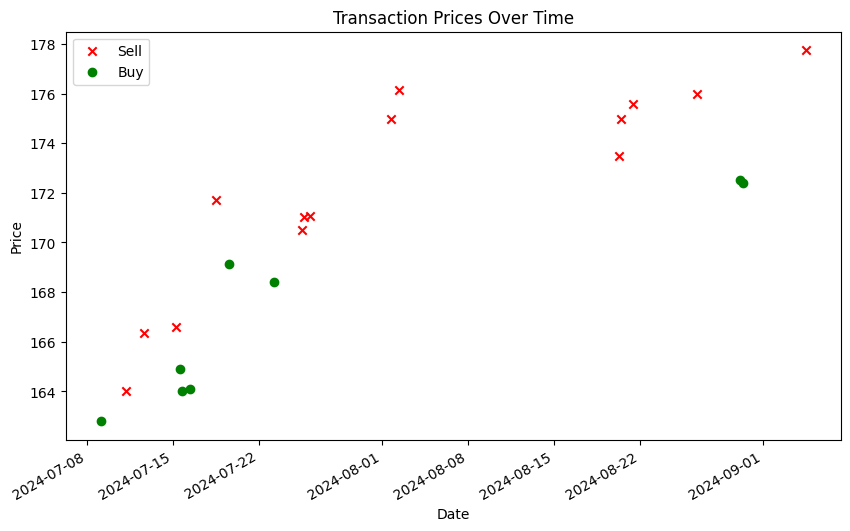

Running Simulation for RSI with PEP from 2024-07-04 to 2024-09-04
Number of Transactions:  22
Buys:  8 Sells:  14
Open Price, Close Price:  163.06 178.51
Beginning Cash and Shares:  500000.0 3066.355942597817
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  650000.0 2228.3175048063317
End Portfolio Value:  1047776.9577829782

Model Profit Percentage:  4.777695778297819
Market Change w/o trades 4.737519931313624

Model outperforms market by 0.04017584698419441 %


Invest RSI for ABBV from 2024-07-04 to 2024-09-04
Number of Data Points: 487


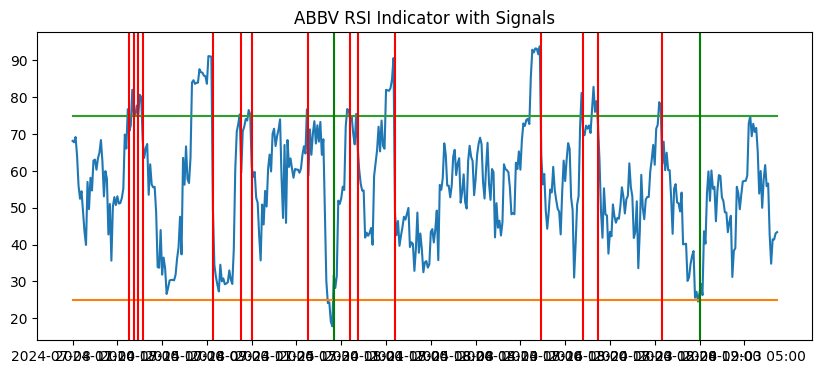

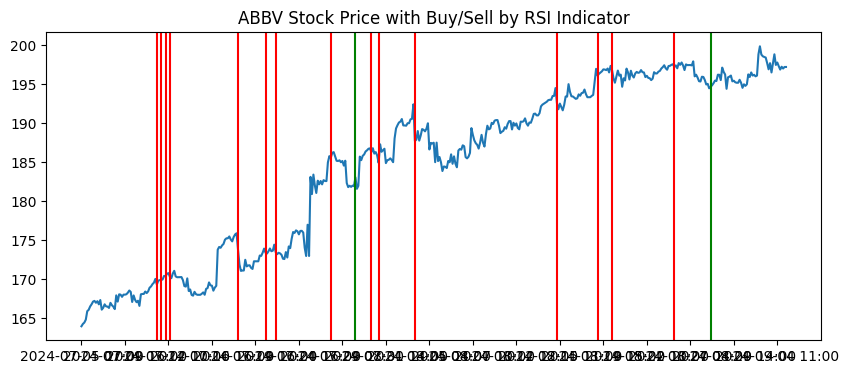

Transactions:  [['2024-07-11 14:00', 169.34, 'Sell'], ['2024-07-11 17:00', 169.91, 'Sell'], ['2024-07-12 08:00', 170.4, 'Sell'], ['2024-07-12 11:00', 170.34, 'Sell'], ['2024-07-18 13:00', 173.815, 'Sell'], ['2024-07-22 13:00', 173.41, 'Sell'], ['2024-07-23 11:00', 173.48, 'Sell'], ['2024-07-26 11:00', 185.58, 'Sell'], ['2024-07-29 17:00', 183.06, 'Buy'], ['2024-07-30 17:00', 186.3, 'Sell'], ['2024-07-31 09:00', 184.92, 'Sell'], ['2024-08-02 10:00', 187.72, 'Sell'], ['2024-08-15 09:00', 192.545, 'Sell'], ['2024-08-19 11:00', 196.09, 'Sell'], ['2024-08-20 09:00', 196.79, 'Sell'], ['2024-08-26 07:00', 197.2, 'Sell'], ['2024-08-28 12:00', 194.66, 'Buy']]


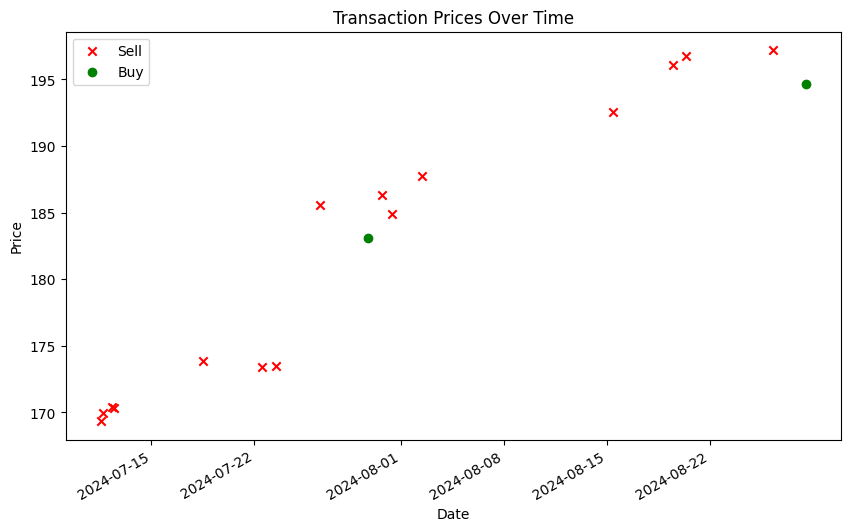

Running Simulation for RSI with ABBV from 2024-07-04 to 2024-09-04
Number of Transactions:  17
Buys:  2 Sells:  15
Open Price, Close Price:  164 197.2
Beginning Cash and Shares:  500000.0 3048.7804878048782
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  825000.0 1245.000556030311
End Portfolio Value:  1070514.1096491772

Model Profit Percentage:  7.051410964917718
Market Change w/o trades 10.12195121951219

Model outperforms market by -3.070540254594473 %


Invest RSI for KO from 2024-07-04 to 2024-09-04
Number of Data Points: 652


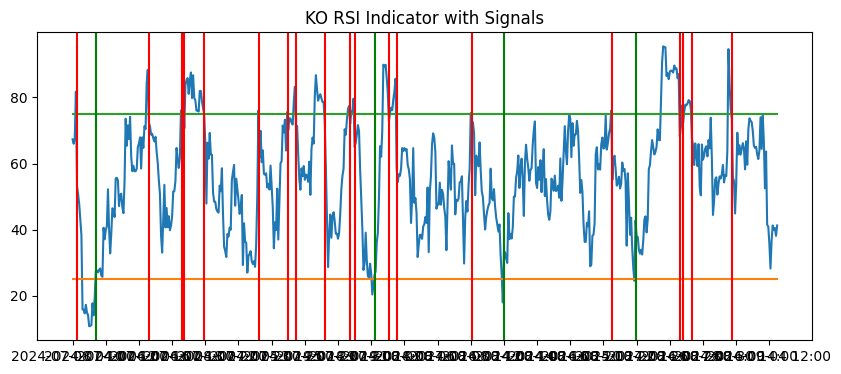

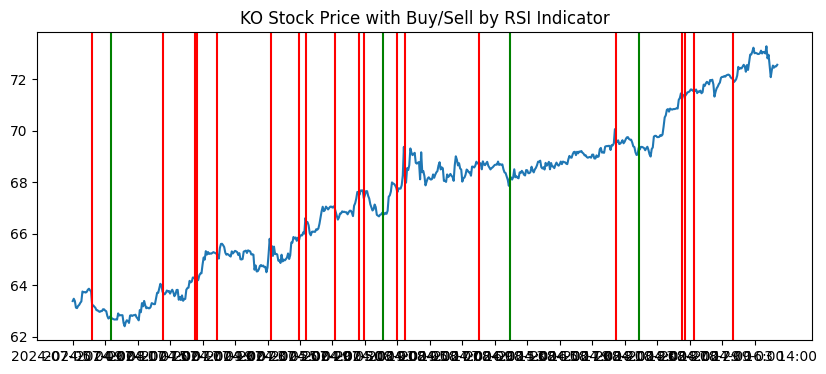

Transactions:  [['2024-07-08 09:00', 63.2, 'Sell'], ['2024-07-09 13:00', 62.795, 'Buy'], ['2024-07-12 15:00', 63.74, 'Sell'], ['2024-07-16 17:00', 64.3, 'Sell'], ['2024-07-16 19:00', 64.17, 'Sell'], ['2024-07-18 06:00', 65.21, 'Sell'], ['2024-07-23 08:00', 65.37, 'Sell'], ['2024-07-24 19:00', 65.73, 'Sell'], ['2024-07-25 10:00', 66.435, 'Sell'], ['2024-07-29 07:00', 67, 'Sell'], ['2024-07-30 14:00', 67.51, 'Sell'], ['2024-07-30 18:00', 67.3689, 'Sell'], ['2024-08-01 06:00', 66.8, 'Buy'], ['2024-08-01 19:00', 67.6104, 'Sell'], ['2024-08-02 10:00', 68.14, 'Sell'], ['2024-08-08 15:00', 68.73, 'Sell'], ['2024-08-12 14:00', 68.185, 'Buy'], ['2024-08-21 10:00', 69.53, 'Sell'], ['2024-08-22 15:00', 69.335, 'Buy'], ['2024-08-27 10:00', 71.2325, 'Sell'], ['2024-08-27 13:00', 71.355, 'Sell'], ['2024-08-28 06:00', 71.54, 'Sell'], ['2024-08-30 10:00', 72.025, 'Sell']]


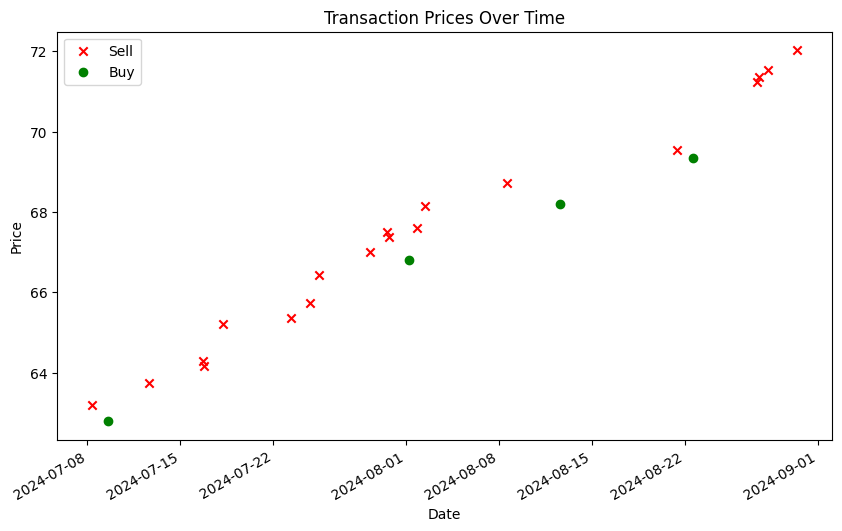

Running Simulation for RSI with KO from 2024-07-04 to 2024-09-04
Number of Transactions:  23
Buys:  4 Sells:  19
Open Price, Close Price:  63.38 72.56
Beginning Cash and Shares:  500000.0 7888.9239507731145
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  875000.0 2327.4885087184725
End Portfolio Value:  1043882.5661926124

Model Profit Percentage:  4.388256619261241
Market Change w/o trades 7.242032186809719

Model outperforms market by -2.853775567548478 %


Invest RSI for SPY from 2024-07-04 to 2024-09-04
Number of Data Points: 689


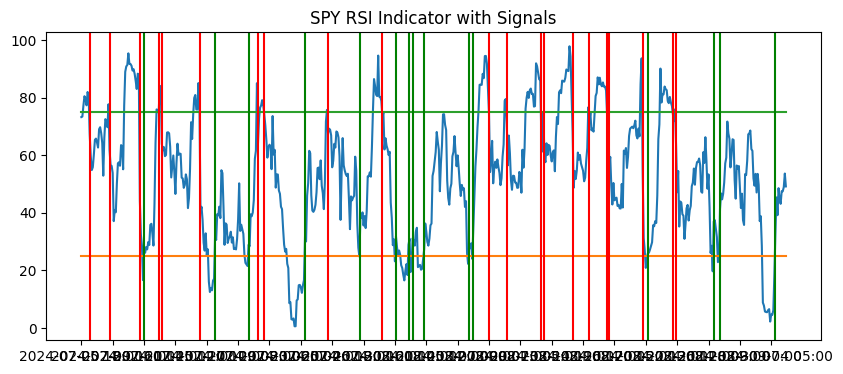

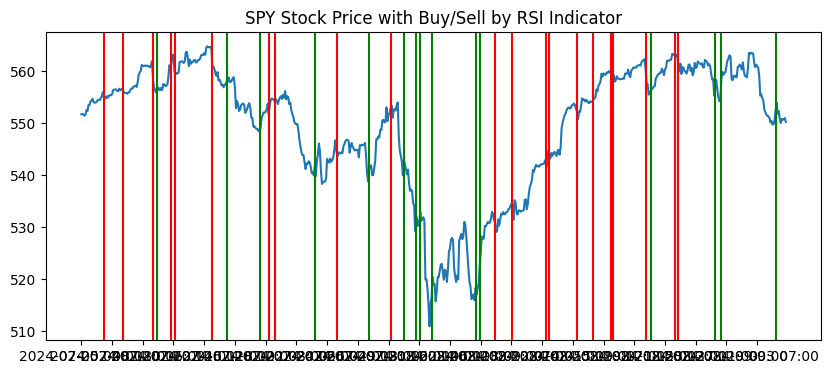

Transactions:  [['2024-07-08 10:00', 555.2, 'Sell'], ['2024-07-09 13:00', 556.14, 'Sell'], ['2024-07-11 10:00', 558.47, 'Sell'], ['2024-07-11 14:00', 557.16, 'Buy'], ['2024-07-12 12:00', 561.64, 'Sell'], ['2024-07-12 15:00', 559.9, 'Sell'], ['2024-07-17 04:00', 560.71, 'Sell'], ['2024-07-17 18:00', 558.14, 'Buy'], ['2024-07-19 18:00', 548.79, 'Buy'], ['2024-07-22 11:00', 551.76, 'Sell'], ['2024-07-22 17:00', 554.16, 'Sell'], ['2024-07-25 08:00', 541.7, 'Buy'], ['2024-07-26 14:00', 543.57, 'Sell'], ['2024-07-30 13:00', 541.32, 'Buy'], ['2024-07-31 18:00', 552.89, 'Sell'], ['2024-08-01 15:00', 543.04, 'Buy'], ['2024-08-02 11:00', 532.18, 'Buy'], ['2024-08-02 15:00', 532.98, 'Buy'], ['2024-08-05 10:00', 516.43, 'Buy'], ['2024-08-08 04:00', 518.35, 'Buy'], ['2024-08-08 08:00', 522.5, 'Buy'], ['2024-08-09 07:00', 530.84, 'Sell'], ['2024-08-12 08:00', 534.34, 'Sell'], ['2024-08-14 09:00', 541.49, 'Sell'], ['2024-08-14 12:00', 543.08, 'Sell'], ['2024-08-16 07:00', 552.22, 'Sell'], ['2024-08-1

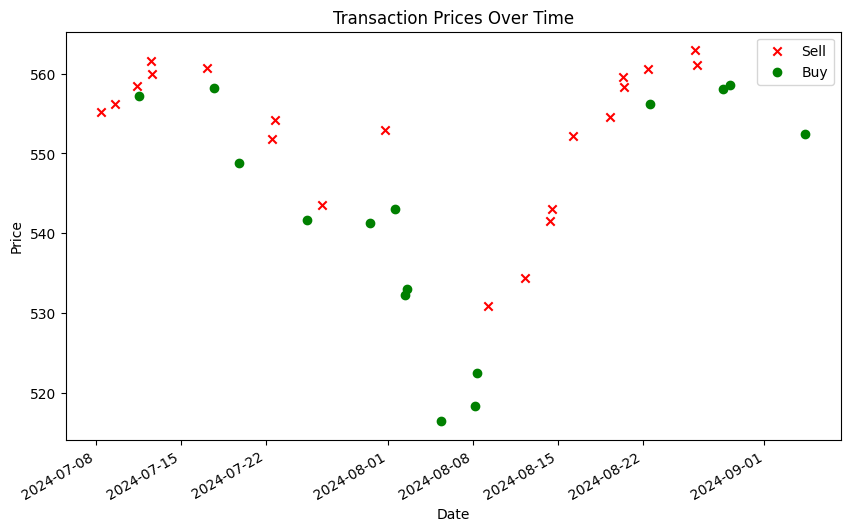

Running Simulation for RSI with SPY from 2024-07-04 to 2024-09-04
Number of Transactions:  36
Buys:  15 Sells:  21
Open Price, Close Price:  551.75 550.28
Beginning Cash and Shares:  500000.0 906.2075215224287
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  650000.0 648.3325827536089
End Portfolio Value:  1006764.4536376558

Model Profit Percentage:  0.6764453637655824
Market Change w/o trades -0.1332125056637995

Model outperforms market by 0.8096578694293819 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for TQQQ from 2024-07-04 to 2024-09-04
Number of Data Points: 688


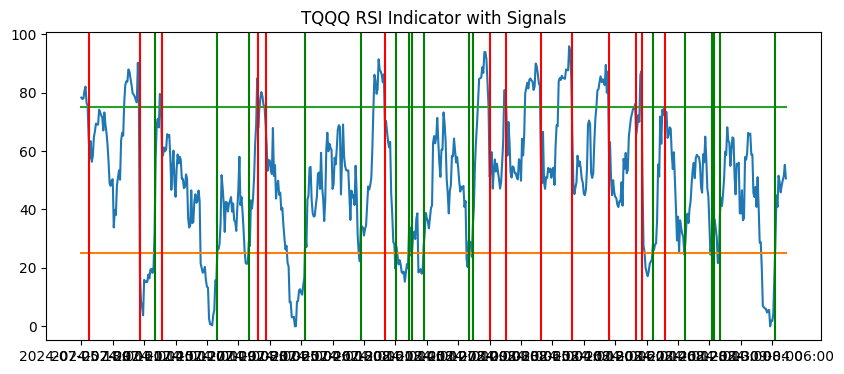

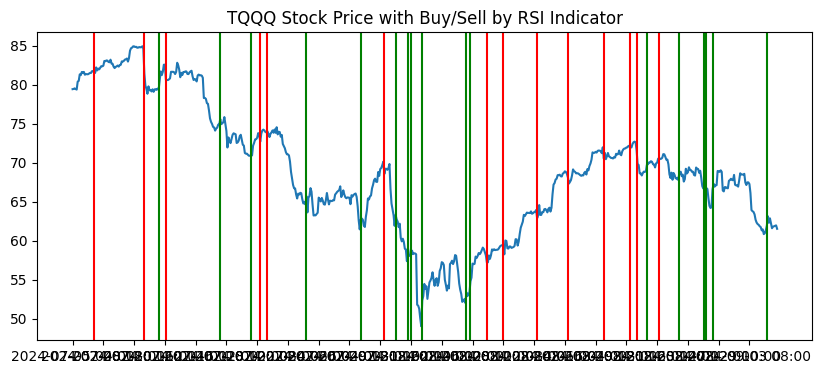

Transactions:  [['2024-07-08 09:00', 81.8403, 'Sell'], ['2024-07-11 10:00', 81.43, 'Sell'], ['2024-07-12 08:00', 79.46, 'Buy'], ['2024-07-12 15:00', 80.63, 'Sell'], ['2024-07-18 04:00', 75.62, 'Buy'], ['2024-07-19 18:00', 70.95, 'Buy'], ['2024-07-22 11:00', 72.715, 'Sell'], ['2024-07-22 18:00', 74.049, 'Sell'], ['2024-07-25 08:00', 65.73, 'Buy'], ['2024-07-30 13:00', 62.725, 'Buy'], ['2024-08-01 04:00', 68.57, 'Sell'], ['2024-08-01 15:00', 63.33, 'Buy'], ['2024-08-02 11:00', 59.08, 'Buy'], ['2024-08-02 14:00', 58.14, 'Buy'], ['2024-08-05 09:00', 52.365, 'Buy'], ['2024-08-08 04:00', 53.4, 'Buy'], ['2024-08-08 08:00', 54.81, 'Buy'], ['2024-08-09 08:00', 57.2, 'Sell'], ['2024-08-12 08:00', 59.41, 'Sell'], ['2024-08-14 09:00', 62.8991, 'Sell'], ['2024-08-16 07:00', 68.14, 'Sell'], ['2024-08-20 10:00', 70.555, 'Sell'], ['2024-08-22 04:00', 71.98, 'Sell'], ['2024-08-22 10:00', 71.58, 'Sell'], ['2024-08-23 04:00', 69.75, 'Buy'], ['2024-08-23 16:00', 70.42, 'Sell'], ['2024-08-26 19:00', 68.219

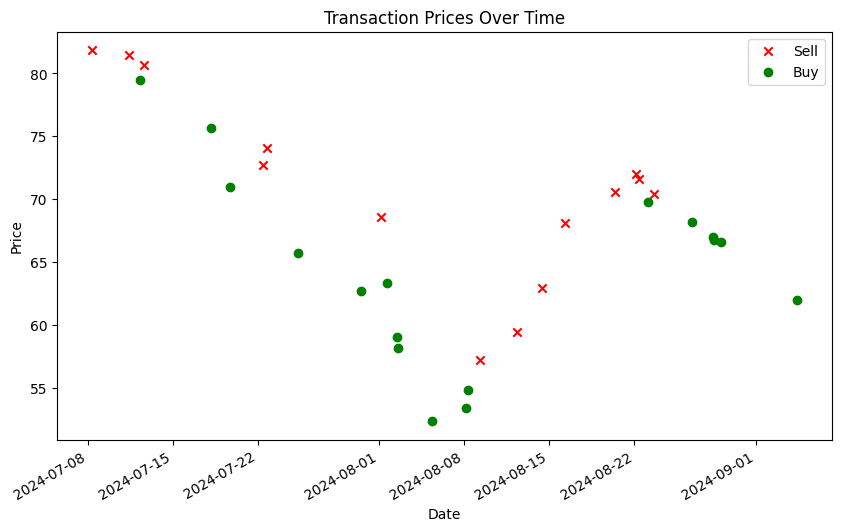

Running Simulation for RSI with TQQQ from 2024-07-04 to 2024-09-04
Number of Transactions:  31
Buys:  17 Sells:  14
Open Price, Close Price:  79.45 61.54
Beginning Cash and Shares:  500000.0 6293.266205160478
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  425000.0 7974.065347025357
End Portfolio Value:  915723.9814559405

Model Profit Percentage:  -8.427601854405948
Market Change w/o trades -11.271239773442417

Model outperforms market by 2.8436379190364693 %


Invest RSI for QQQ from 2024-07-04 to 2024-09-04
Number of Data Points: 688


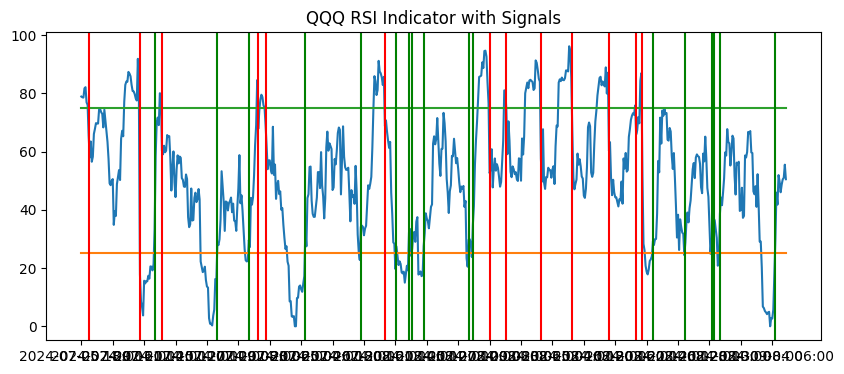

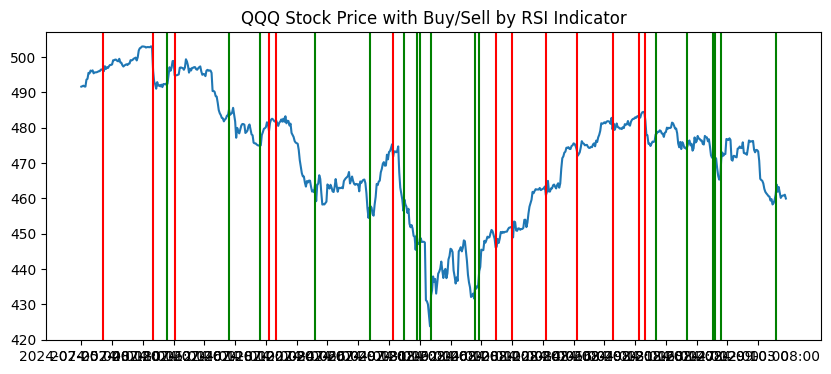

Transactions:  [['2024-07-08 09:00', 496.62, 'Sell'], ['2024-07-11 10:00', 496.101, 'Sell'], ['2024-07-12 08:00', 492.42, 'Buy'], ['2024-07-12 15:00', 494.84, 'Sell'], ['2024-07-18 04:00', 485.14, 'Buy'], ['2024-07-19 18:00', 475.05, 'Buy'], ['2024-07-22 11:00', 479.065, 'Sell'], ['2024-07-22 18:00', 482.03, 'Sell'], ['2024-07-25 08:00', 464.18, 'Buy'], ['2024-07-30 13:00', 457.4, 'Buy'], ['2024-08-01 04:00', 471.78, 'Sell'], ['2024-08-01 15:00', 459.68, 'Buy'], ['2024-08-02 11:00', 449.58, 'Buy'], ['2024-08-02 14:00', 447.31, 'Buy'], ['2024-08-05 09:00', 432.53, 'Buy'], ['2024-08-08 04:00', 435.45, 'Buy'], ['2024-08-08 08:00', 439.43, 'Buy'], ['2024-08-09 08:00', 446.14, 'Sell'], ['2024-08-12 08:00', 451.86, 'Sell'], ['2024-08-14 09:00', 460.89, 'Sell'], ['2024-08-16 07:00', 473.796, 'Sell'], ['2024-08-20 10:00', 479.55, 'Sell'], ['2024-08-22 04:00', 482.9, 'Sell'], ['2024-08-22 10:00', 481.99, 'Sell'], ['2024-08-23 04:00', 478.11, 'Buy'], ['2024-08-26 19:00', 474.8, 'Buy'], ['2024-08

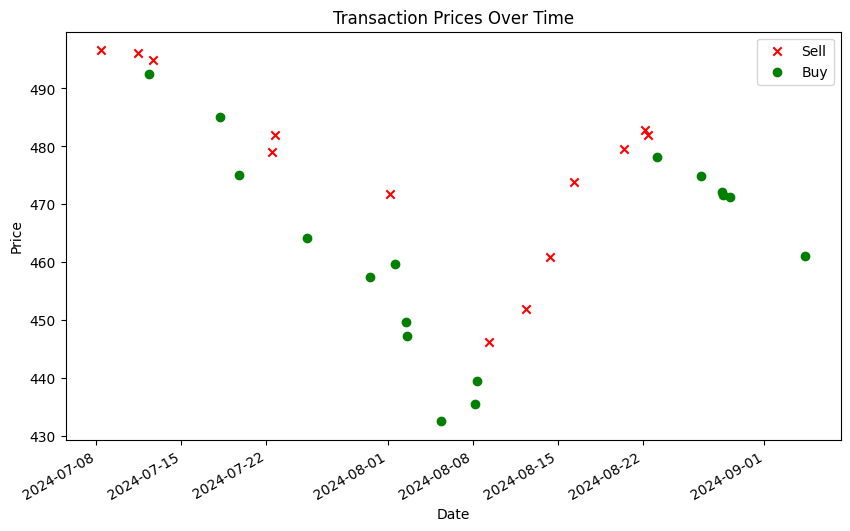

Running Simulation for RSI with QQQ from 2024-07-04 to 2024-09-04
Number of Transactions:  30
Buys:  17 Sells:  13
Open Price, Close Price:  491.63 459.96
Beginning Cash and Shares:  500000.0 1017.0249984744626
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  400000.0 1254.2179169809212
End Portfolio Value:  976890.0730945445

Model Profit Percentage:  -2.3109926905455533
Market Change w/o trades -3.2209181701686247

Model outperforms market by 0.9099254796230714 %


Invest RSI for COIN from 2024-07-04 to 2024-09-04
Number of Data Points: 688


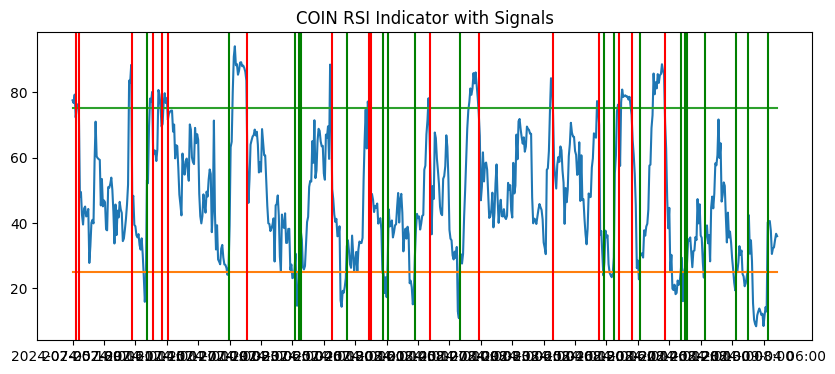

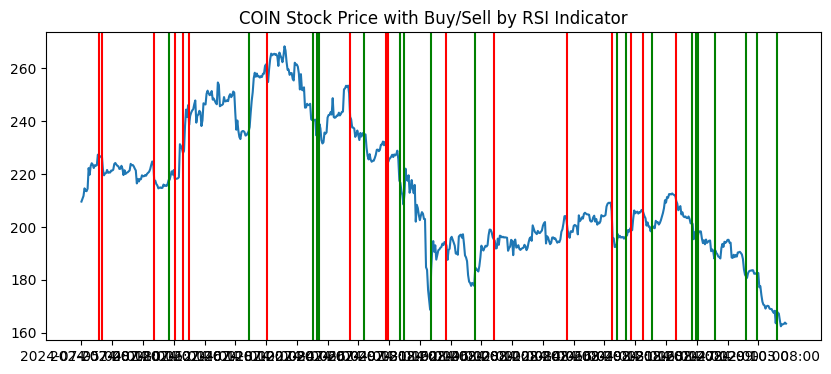

Transactions:  [['2024-07-08 05:00', 225.82, 'Sell'], ['2024-07-08 08:00', 226.49, 'Sell'], ['2024-07-11 11:00', 217.1849, 'Sell'], ['2024-07-12 09:00', 217.7, 'Buy'], ['2024-07-12 15:00', 218.05, 'Sell'], ['2024-07-15 07:00', 227.9, 'Sell'], ['2024-07-15 13:00', 238.54, 'Sell'], ['2024-07-19 07:00', 236.05, 'Buy'], ['2024-07-22 09:00', 254.79, 'Sell'], ['2024-07-25 06:00', 240.6, 'Buy'], ['2024-07-25 10:00', 237.93, 'Buy'], ['2024-07-25 12:00', 238.92, 'Buy'], ['2024-07-29 10:00', 241.59, 'Sell'], ['2024-07-30 08:00', 234.9, 'Buy'], ['2024-07-31 13:00', 230.7, 'Sell'], ['2024-07-31 15:00', 224.47, 'Sell'], ['2024-08-01 11:00', 216.665, 'Buy'], ['2024-08-01 15:00', 212.64, 'Buy'], ['2024-08-05 09:00', 183.95, 'Buy'], ['2024-08-06 07:00', 194.23, 'Sell'], ['2024-08-08 04:00', 184.75, 'Buy'], ['2024-08-09 06:00', 195.39, 'Sell'], ['2024-08-15 13:00', 202.62, 'Sell'], ['2024-08-20 09:00', 206.05, 'Sell'], ['2024-08-20 14:00', 193.67, 'Buy'], ['2024-08-21 07:00', 196.55, 'Buy'], ['2024-08-

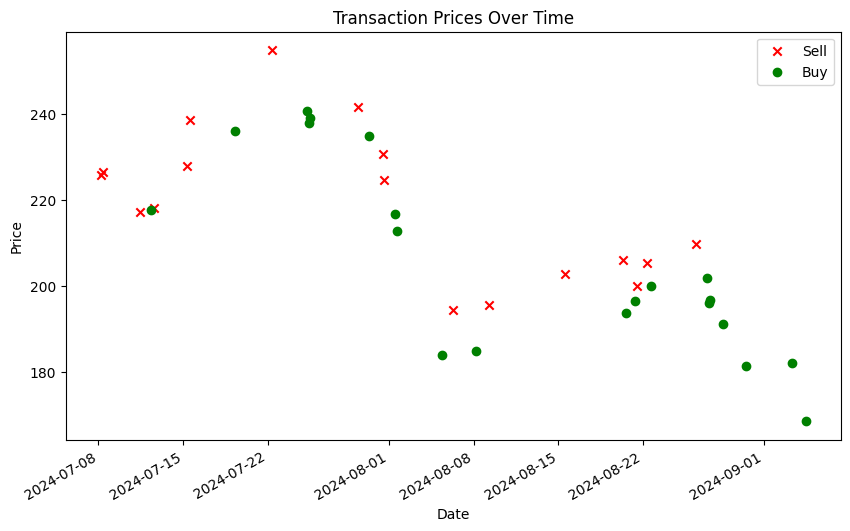

Running Simulation for RSI with COIN from 2024-07-04 to 2024-09-04
Number of Transactions:  37
Buys:  20 Sells:  17
Open Price, Close Price:  209.58 163.5
Beginning Cash and Shares:  500000.0 2385.7238286096
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  425000.0 2890.8515222420597
End Portfolio Value:  897654.2238865767

Model Profit Percentage:  -10.234577611342328
Market Change w/o trades -10.993415402233039

Model outperforms market by 0.7588377908907109 %


Invest RSI for MSTR from 2024-07-04 to 2024-09-04
Number of Data Points: 649


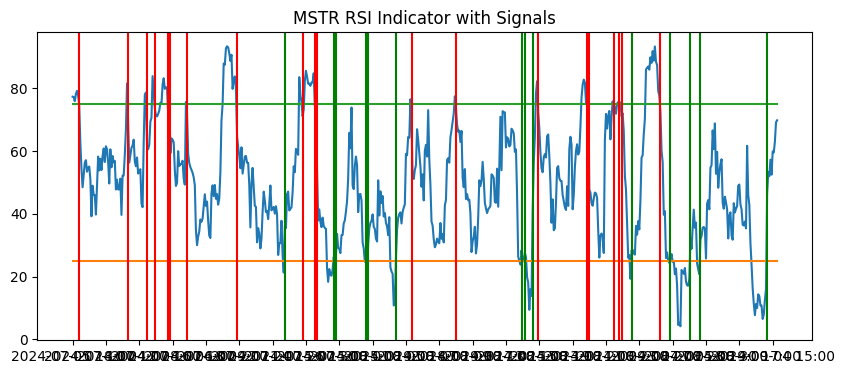

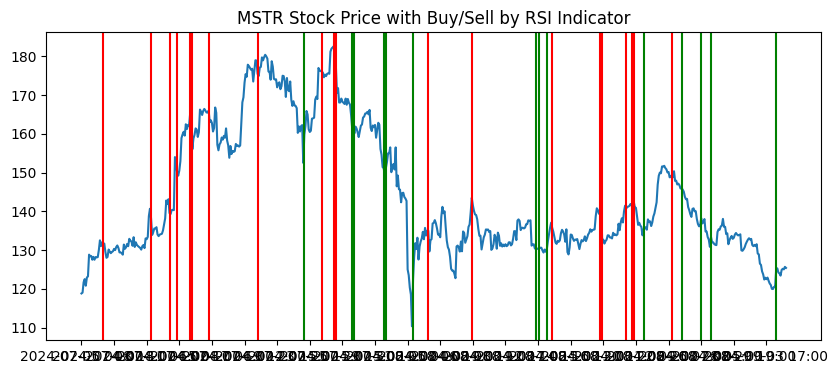

Transactions:  [['2024-07-08 08:00', 131.3742, 'Sell'], ['2024-07-11 10:00', 138.264, 'Sell'], ['2024-07-12 15:00', 139.516, 'Sell'], ['2024-07-15 06:00', 150, 'Sell'], ['2024-07-15 18:00', 165.302, 'Sell'], ['2024-07-16 04:00', 156.011, 'Sell'], ['2024-07-16 19:00', 166, 'Sell'], ['2024-07-22 09:00', 175.477, 'Sell'], ['2024-07-25 10:00', 159.826, 'Buy'], ['2024-07-26 12:00', 176.058, 'Sell'], ['2024-07-29 07:00', 182.6, 'Sell'], ['2024-07-29 09:00', 177.564, 'Sell'], ['2024-07-30 10:00', 161.351, 'Buy'], ['2024-07-30 12:00', 160.0985, 'Buy'], ['2024-08-01 13:00', 151.13, 'Buy'], ['2024-08-01 15:00', 151.165, 'Buy'], ['2024-08-05 09:00', 122.5, 'Buy'], ['2024-08-06 08:00', 135, 'Sell'], ['2024-08-08 18:00', 143.5, 'Sell'], ['2024-08-14 13:00', 130.25, 'Buy'], ['2024-08-14 16:00', 130.66, 'Buy'], ['2024-08-15 07:00', 130.17, 'Buy'], ['2024-08-15 12:00', 135.675, 'Sell'], ['2024-08-20 08:00', 139.79, 'Sell'], ['2024-08-20 10:00', 132.1099, 'Sell'], ['2024-08-21 16:00', 140.7, 'Sell'], [

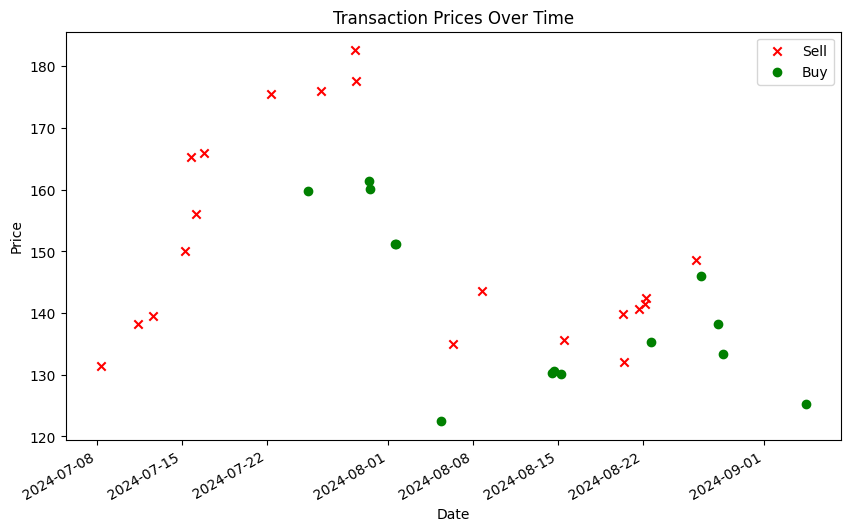

Running Simulation for RSI with MSTR from 2024-07-04 to 2024-09-04
Number of Transactions:  34
Buys:  14 Sells:  20
Open Price, Close Price:  118.8 125.39
Beginning Cash and Shares:  500000.0 4208.754208754209
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  650000.0 3359.307860570259
End Portfolio Value:  1071223.6126369047

Model Profit Percentage:  7.12236126369047
Market Change w/o trades 2.7735690235690247

Model outperforms market by 4.348792240121446 %


Profits for each stock: {'AAPL': 0.26210776883455694, 'MSFT': -5.7610511178424, 'GOOGL': -8.053410299128712, 'GOOG': -7.9932205592201555, 'AMZN': -4.942060424320354, 'TSLA': -3.6088081897923723, 'NVDA': -6.412616491764737, 'BRK.B': 5.644901234885095, 'META': 0.24883281084116313, 'UNH': 8.955601633480518, 'JNJ': 6.314105962396041, 'V': 1.463505358358065, 'WMT': 5.581454611149477, 'XOM': 0.37945500415081623, 'PG': 3.4300728125074413, 'JPM': 1.1964062268902782, 'MA': 3.331588509874069, 'LLY': 3.6691460961862465, 'HD': 5.

In [29]:
#test
tickers = top_tickers
# start_date = "2024-06-22"
# end_date =  "2024-08-22"
start_date = "2024-07-04"
end_date =  "2024-09-04"
initial_portfolio_value = 1000000
count = 0

for ticker in tickers:
    if count % 5 == 0 and count != 0:
        print("Waiting for 60 seconds to avoid rate limit")
        time.sleep(61)
    count += 1
        

    print("Invest RSI for", ticker, "from" , start_date, "to" , end_date)
    
    data = get_data(ticker, start_date, end_date)
    # replace start price with start price of stock (you can find it in yahoo finance)
    start_price = data[0].close
   
    initial_cash = 0.5 * initial_portfolio_value
    initial_shares = (0.5 * initial_portfolio_value/start_price) if start_price > 0 else 1000
    percent_invest = 5
    alpha, profit = test_model(ticker, data, start_date, end_date, initial_cash, initial_shares, percent_invest) # can only run for about 1.5 yrs
    profits_dict[ticker] = profit
    alphas_dict[ticker] = alpha
    print()
    print()
    

print("Profits for each stock:", profits_dict)
print("Alphas for each stock:", alphas_dict)

Average Alpha:  0.06818870338748706


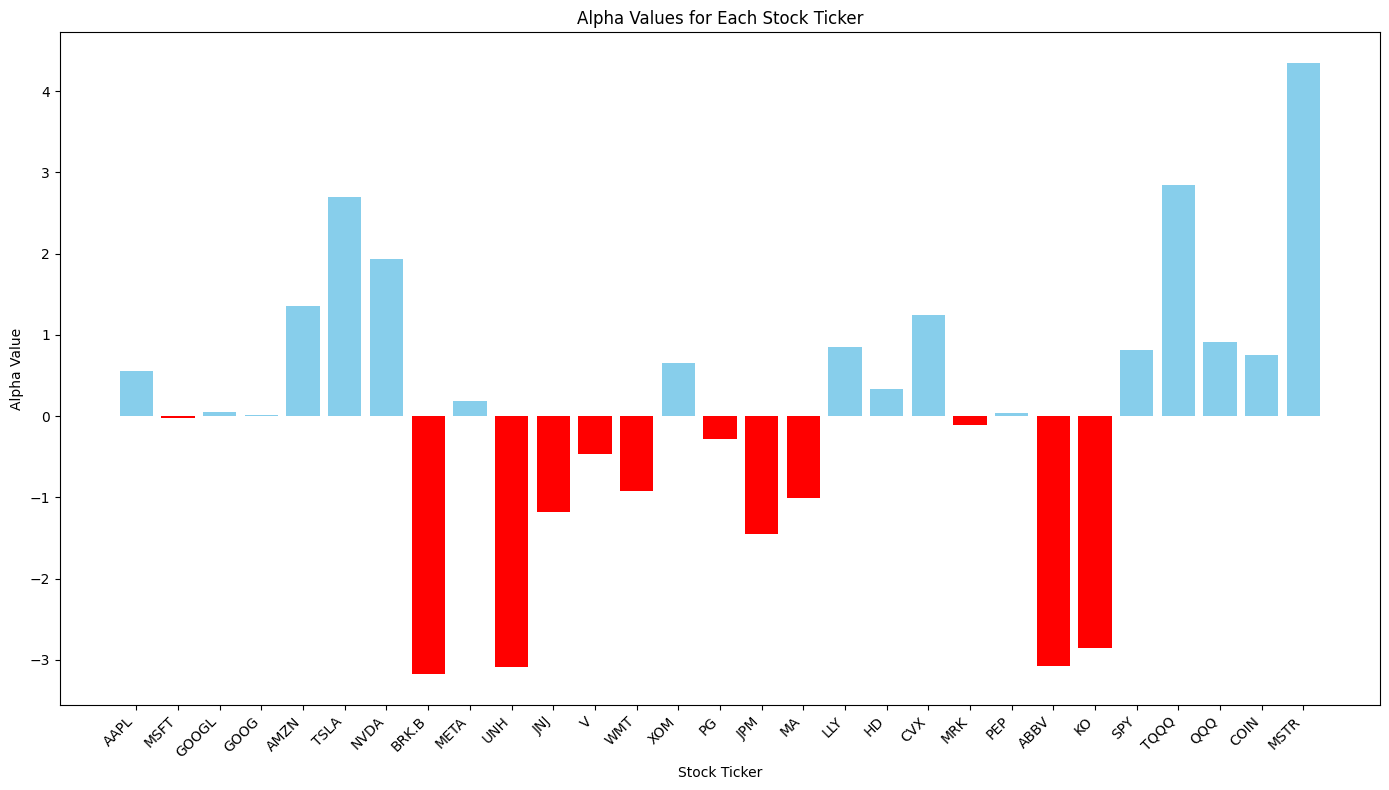

In [30]:
# Create lists of tickers and corresponding alphas
tickers = list(alphas_dict.keys())
alphas = list(alphas_dict.values())
print("Average Alpha: ", sum(alphas)/len(alphas))

colors = ['red' if alpha < 0 else 'skyblue' for alpha in alphas]  # Red for negative, blue for positive

# Plotting the data
plt.figure(figsize=(14, 8))
plt.bar(tickers, alphas, color=colors)

# Labels and title
plt.xlabel('Stock Ticker')
plt.ylabel('Alpha Value')
plt.title('Alpha Values for Each Stock Ticker')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')


# Show the plot
plt.tight_layout()
plt.show()